# init

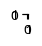

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

## reloading datasets

In [2]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

Peptide   wild_type        HLA  agg_label  mut_len  wt_len seq_id  \
0   AFGSAHLFR   AFGSAHLYR  HLA-A3101          1        9       9  seq_1   
1   AIANRIKFK   AIANRIKSK  HLA-A1101          0        9       9  seq_4   
2   AICKPLHYV   AICKPLHYM  HLA-A0201          0        9       9  seq_5   
3  AIPAMVVPNV  AIPAMVVPNA  HLA-A0201          0       10      10  seq_6   
4  ALEVLQSIPY  APEVLQSIPY  HLA-A0101          0       10      10  seq_7   

   Pos_mut Peptide_mut   core_mut  ... core_blsm_mut_score  aliphatic_index  \
0        0   AFGSAHLFR  AFGSAHLFR  ...                   3        65.555556   
1        0   AIANRIKFK  AIANRIKFK  ...                  -2       108.888889   
2        0   AICKPLHYV  AICKPLHYV  ...                   1       130.000000   
3        0  AIPAMVVPNV  AIPAVVPNV  ...                   0       146.000000   
4        0  ALEVLQSIPY  ALEVLQSIY  ...                  -3       156.000000   

      boman hydrophobicity isoelectric_point     VHSE1     VHSE3     VHSE7  \
0  0.837778       0.455556         10.551759  0.214444 -0.278889  0.193333   
1  1.802222      -0.044444         11.823055 -0.048889  0.125556  0.484444   
2 -0.735556       0.755556          8.530526  0.327778  0.046667 -0.017778   
3 -1.637000       1.590000          6.100000  0.431000 -0.385000 -0.067000   
4 -0.472000       0.740000          3.849983  0.292000 -0.062000 -0.096000   

      VHSE8  trueHLA_EL_rank  
0 -0.192222           0.2470  
1 -0.125556           0.1380  
2  0.263333           0.3610  
3  0.446000           2.2606  
4  0.088000           0.6230  

[5 rows x 39 columns]

In [3]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')

In [4]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [128]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')

In [6]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

In [34]:
cedar_aligned['len_core_mut'] = cedar_aligned['core_mut'].apply(len)
cedar_aligned.len_core_mut.unique()

array([9])

In [306]:
encode_batch_weighted(sample, ics_shannon, None, 9, 'onehot', None, 'core_mut')

before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9169,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.3213],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9634,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9604, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0

In [315]:
weighted_sequences = encode_batch_weighted(sample, ics_dict=ics_shannon, max_len=9, encoding='onehot', blosum_matrix=None, seq_col='core_mut')
# Here added a special argument "true_lens" where we provide the true lengths
freqs = batch_compute_frequency(weighted_sequences.numpy(), true_lens=9)
extra_freqs = batch_find_extra_aa(core_seqs, icore_seqs)
summed = np.add(freqs,extra_freqs)
summed[4:]

before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
xd!! 6


array([[0.10369743, 0.        , 0.        , 0.10237203, 0.        ,
        0.09803756, 0.        , 0.        , 0.        , 0.19956324,
        0.0370485 , 0.        , 0.        , 0.        , 0.09752864,
        0.10269237, 0.        , 0.        , 0.        , 0.04814585],
       [0.10457226, 0.        , 0.        , 0.08788767, 0.        ,
        0.        , 0.10608057, 0.10462533, 0.10660405, 0.10613236,
        0.10538305, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07088175, 0.        , 0.        , 0.01572936]],
      dtype=float32)

In [325]:
x,y = get_dataset(sample, ics_shannon, max_len=9, encoding='onehot', blosum_matrix=None, seq_col='core_mut', hla_col='HLA', target_col='agg_label',
                  rank_col='EL_rank_mut', mask=False, invert=False, add_rank=True, add_aaprop=False, remove_pep=False, icore_bulge=True,
                  core_col='core_mut', icore_col='icore_mut')

True
here
before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
xd!! 6


# value checks

In [121]:
cedar_aligned['ratio_rank'] = cedar_aligned['EL_rank_mut'] / cedar_aligned['EL_rank_wt_aligned']
prime_aligned['ratio_rank'] = prime_aligned['EL_rank_mut'] / prime_aligned['EL_rank_wt_aligned']
nepdb_aligned['ratio_rank'] = nepdb_aligned['EL_rank_mut'] / nepdb_aligned['EL_rank_wt_aligned']
cedar_aligned['ratio_rank_copy'] = cedar_aligned['ratio_rank']
prime_aligned['ratio_rank_copy'] = prime_aligned['ratio_rank']
nepdb_aligned['ratio_rank_copy'] = nepdb_aligned['ratio_rank']

In [122]:
cedar_aligned_expr['ratio_rank'] = cedar_aligned_expr['EL_rank_mut'] / cedar_aligned_expr['EL_rank_wt_aligned']
prime_aligned_expr['ratio_rank'] = prime_aligned_expr['EL_rank_mut'] / prime_aligned_expr['EL_rank_wt_aligned']
nepdb_aligned_expr['ratio_rank'] = nepdb_aligned_expr['EL_rank_mut'] / nepdb_aligned_expr['EL_rank_wt_aligned']

In [ ]:
cedar_aligned_expr = cedar_aligned_expr.to_csv('../data/pepx/230125_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = prime_aligned_expr.to_csv('../data/pepx/230125_prime_aligned_pepx.csv')

nepdb_aligned_expr = nepdb_aligned_expr.to_csv('../data/pepx/230125_nepdb_aligned_pepx.csv')

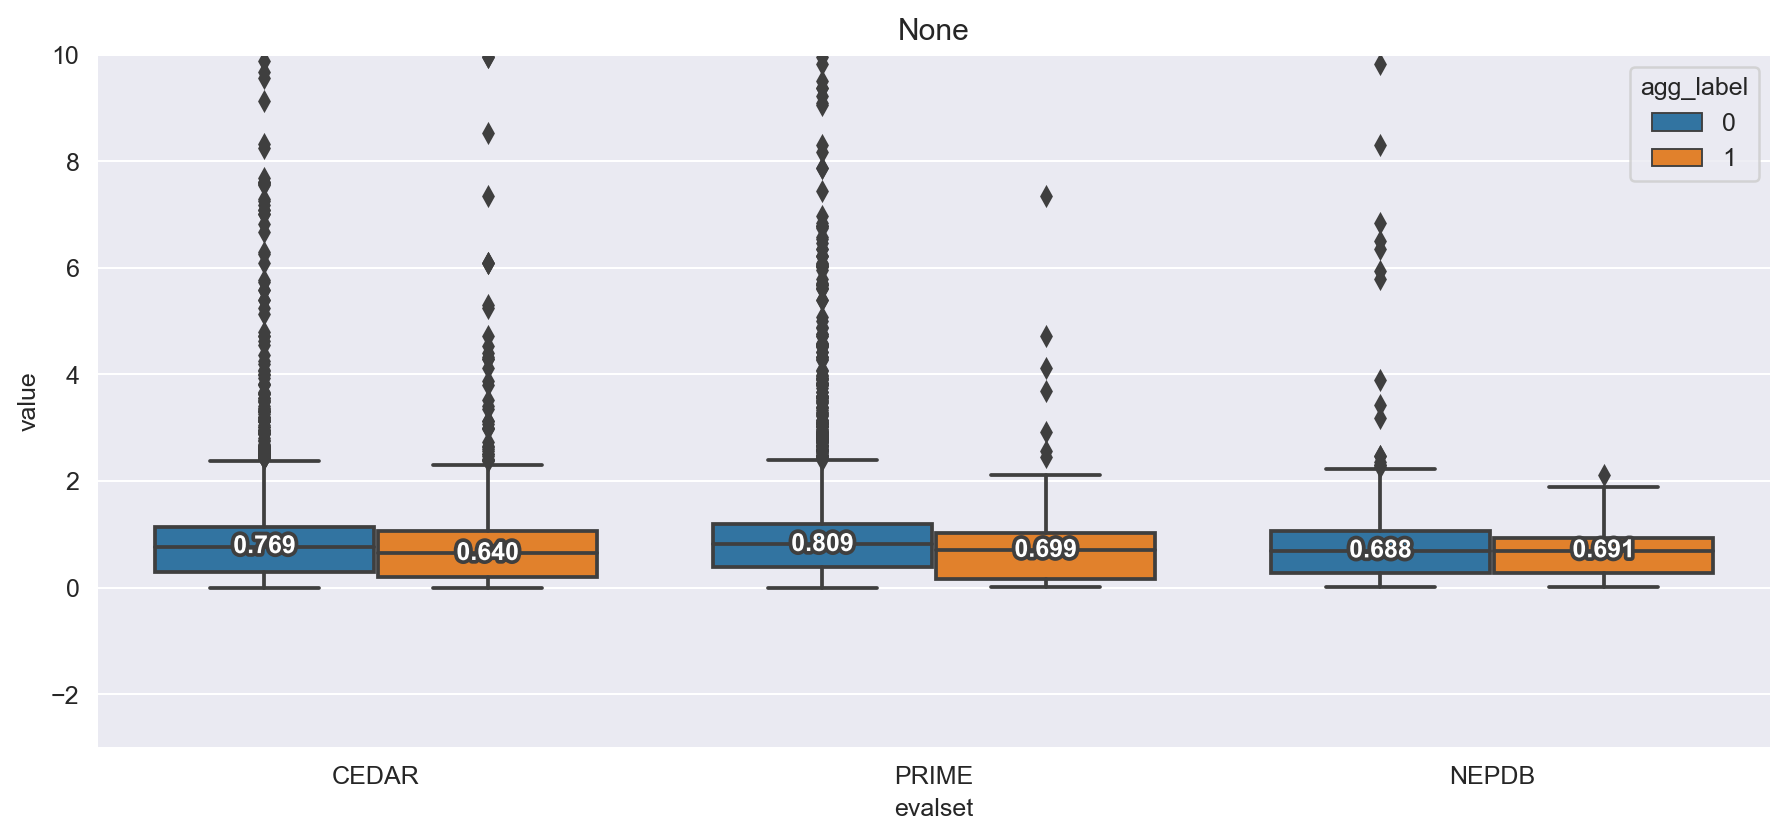

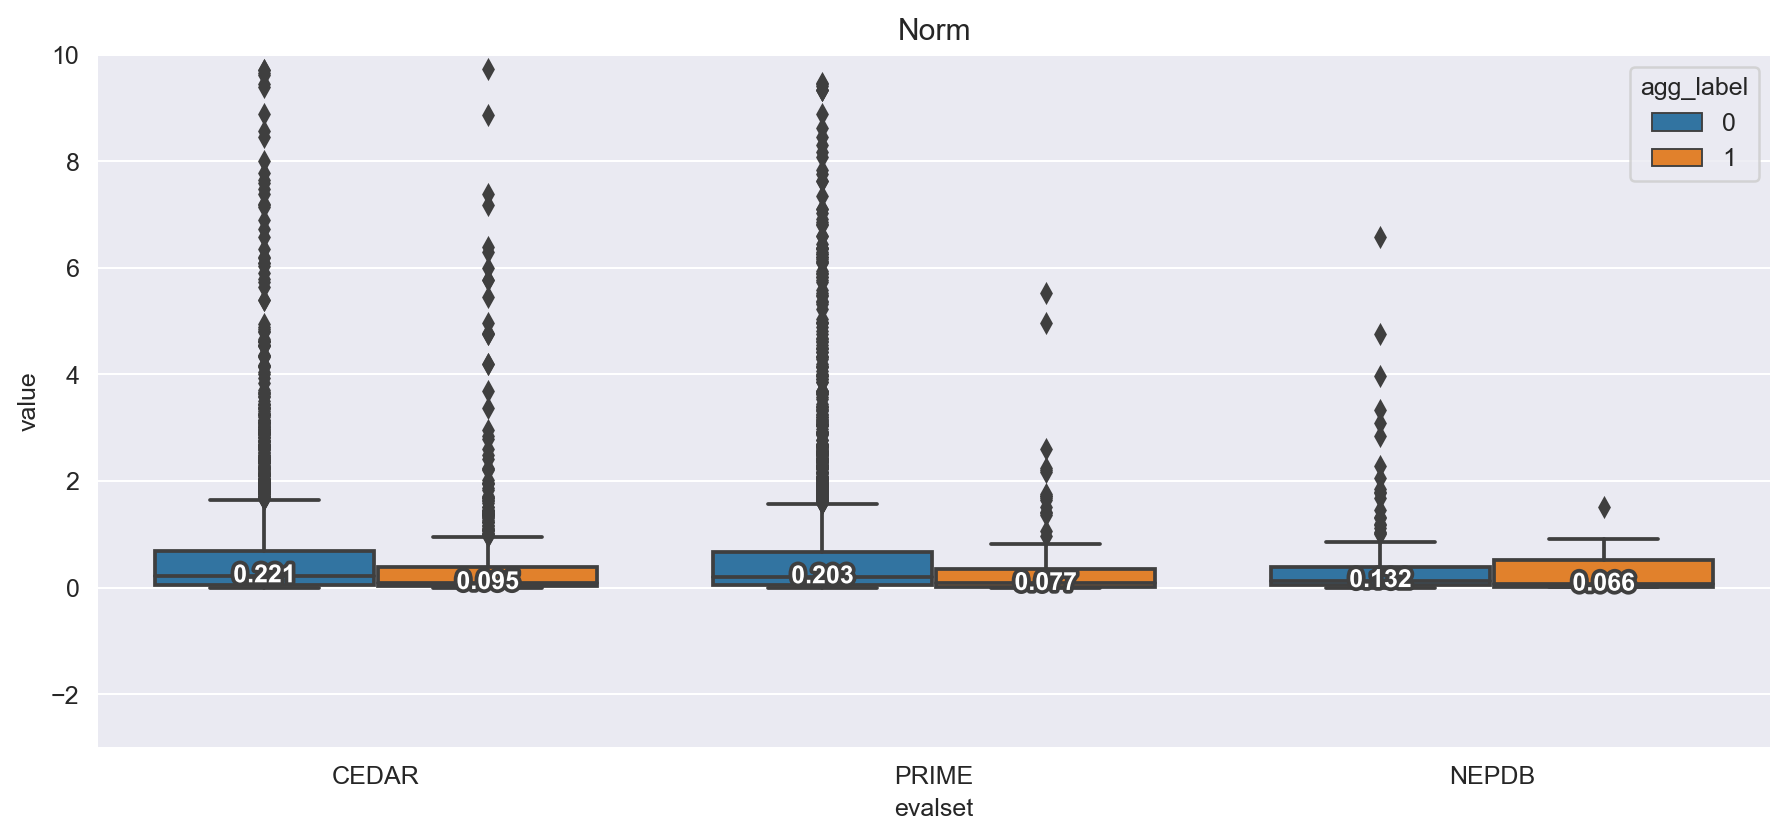

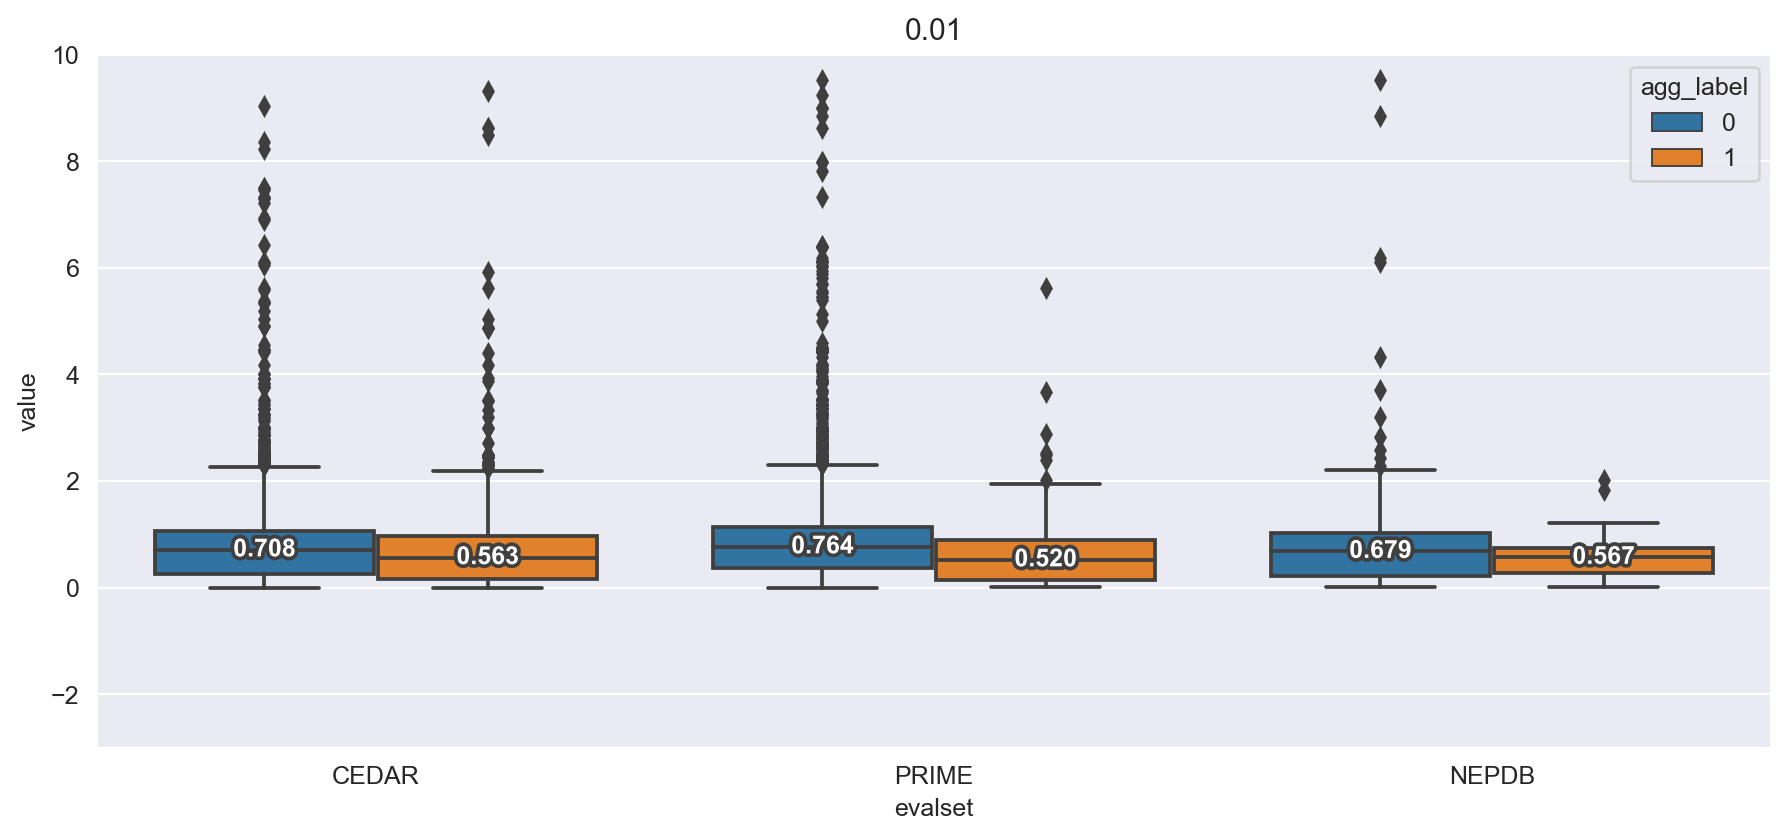

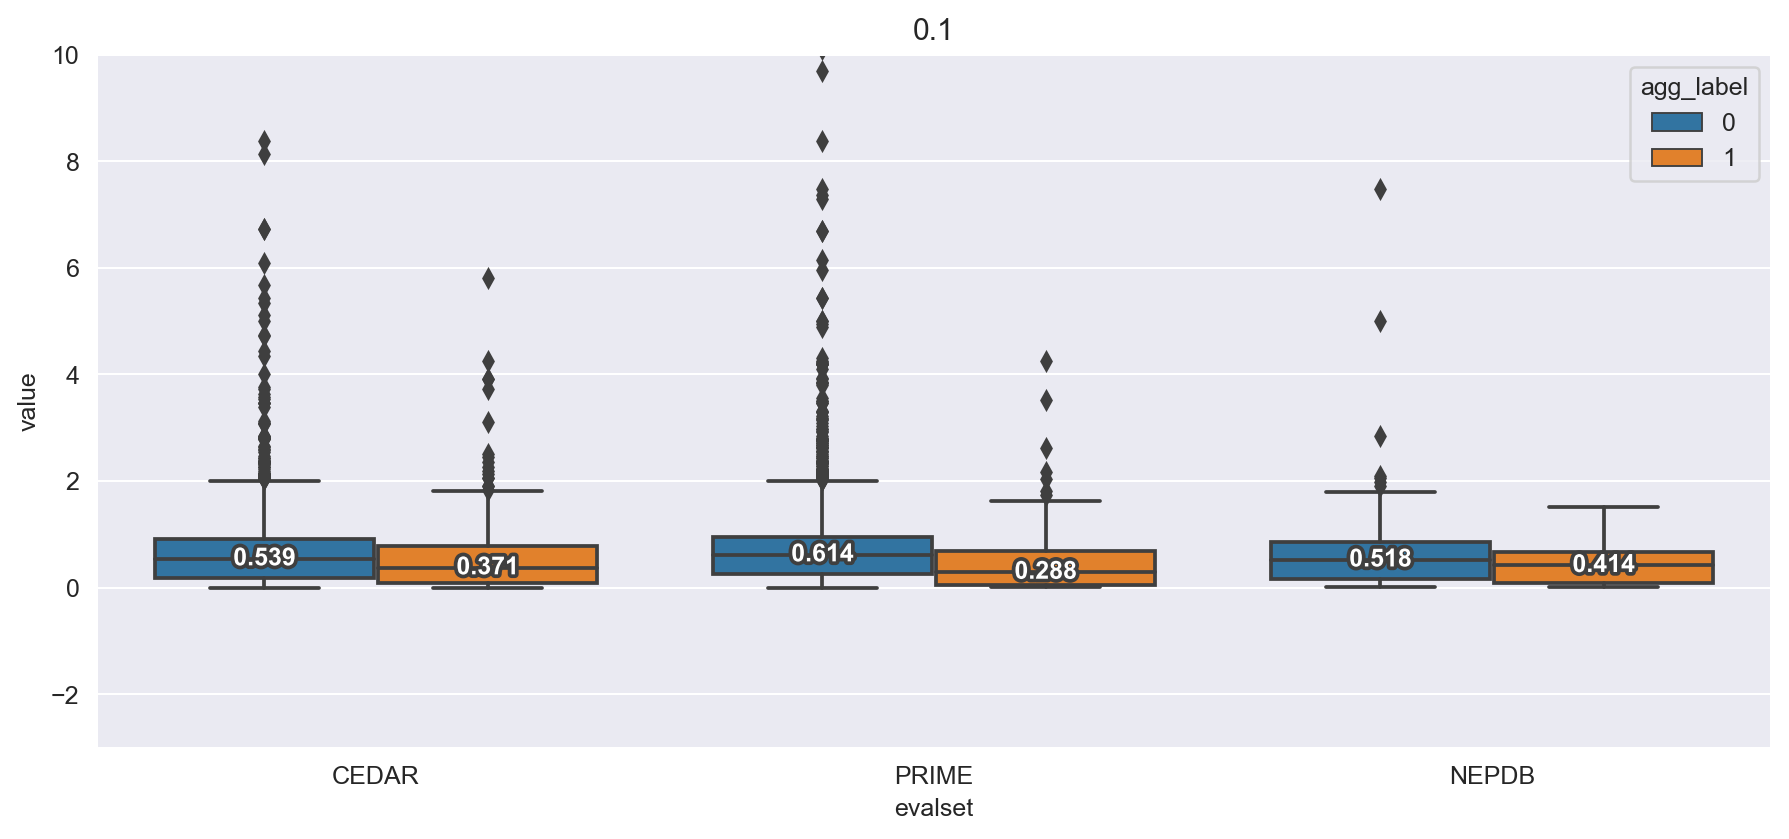

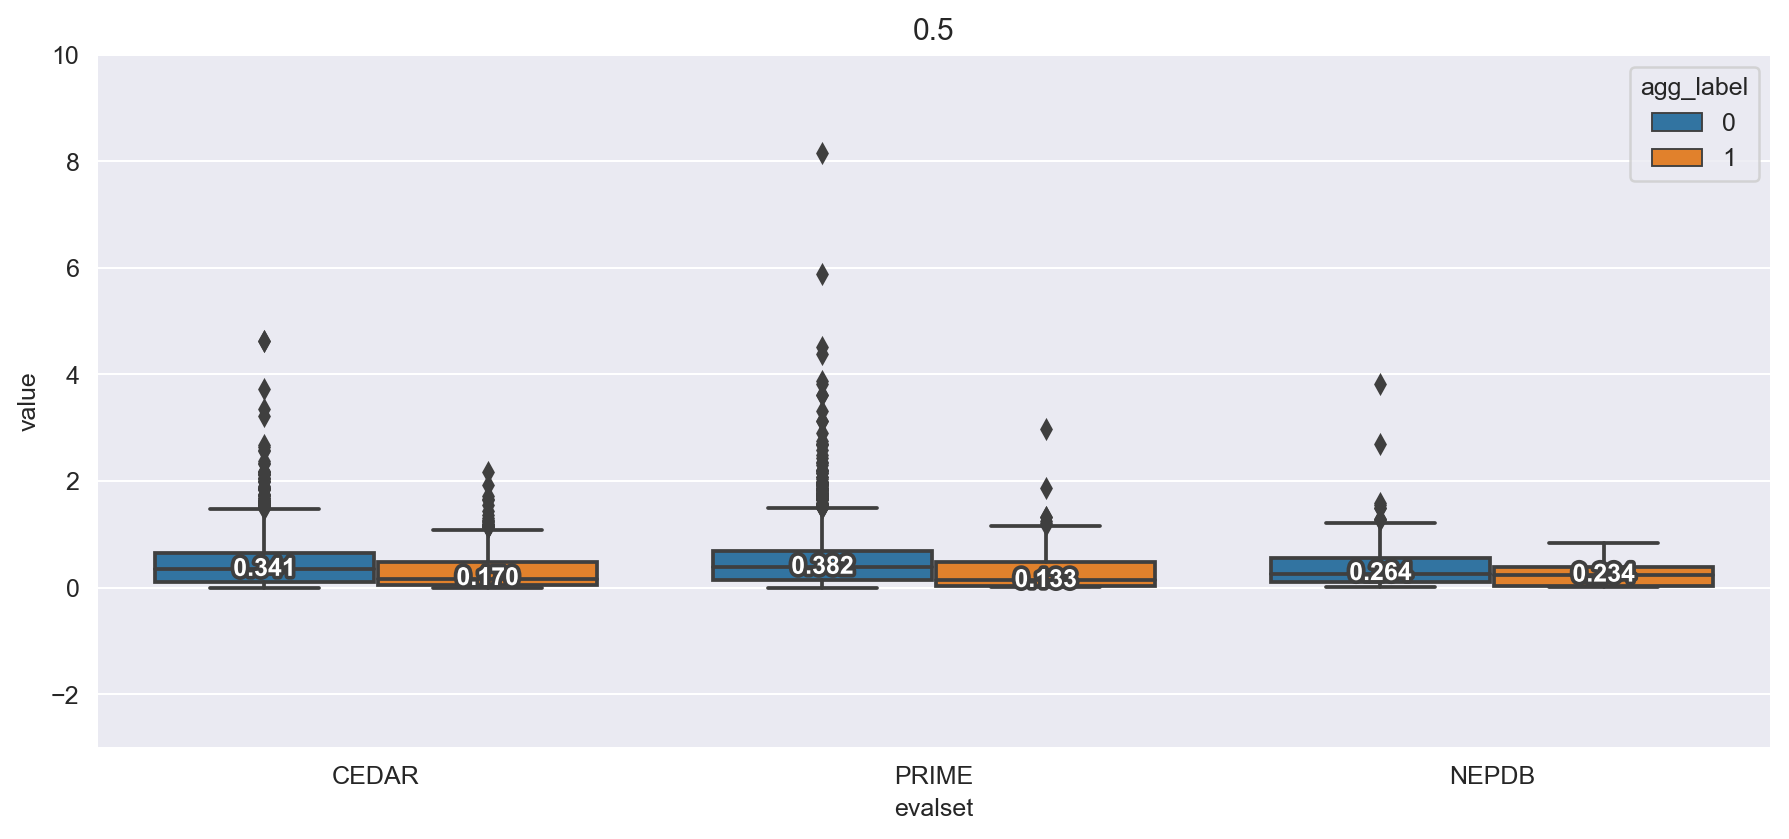

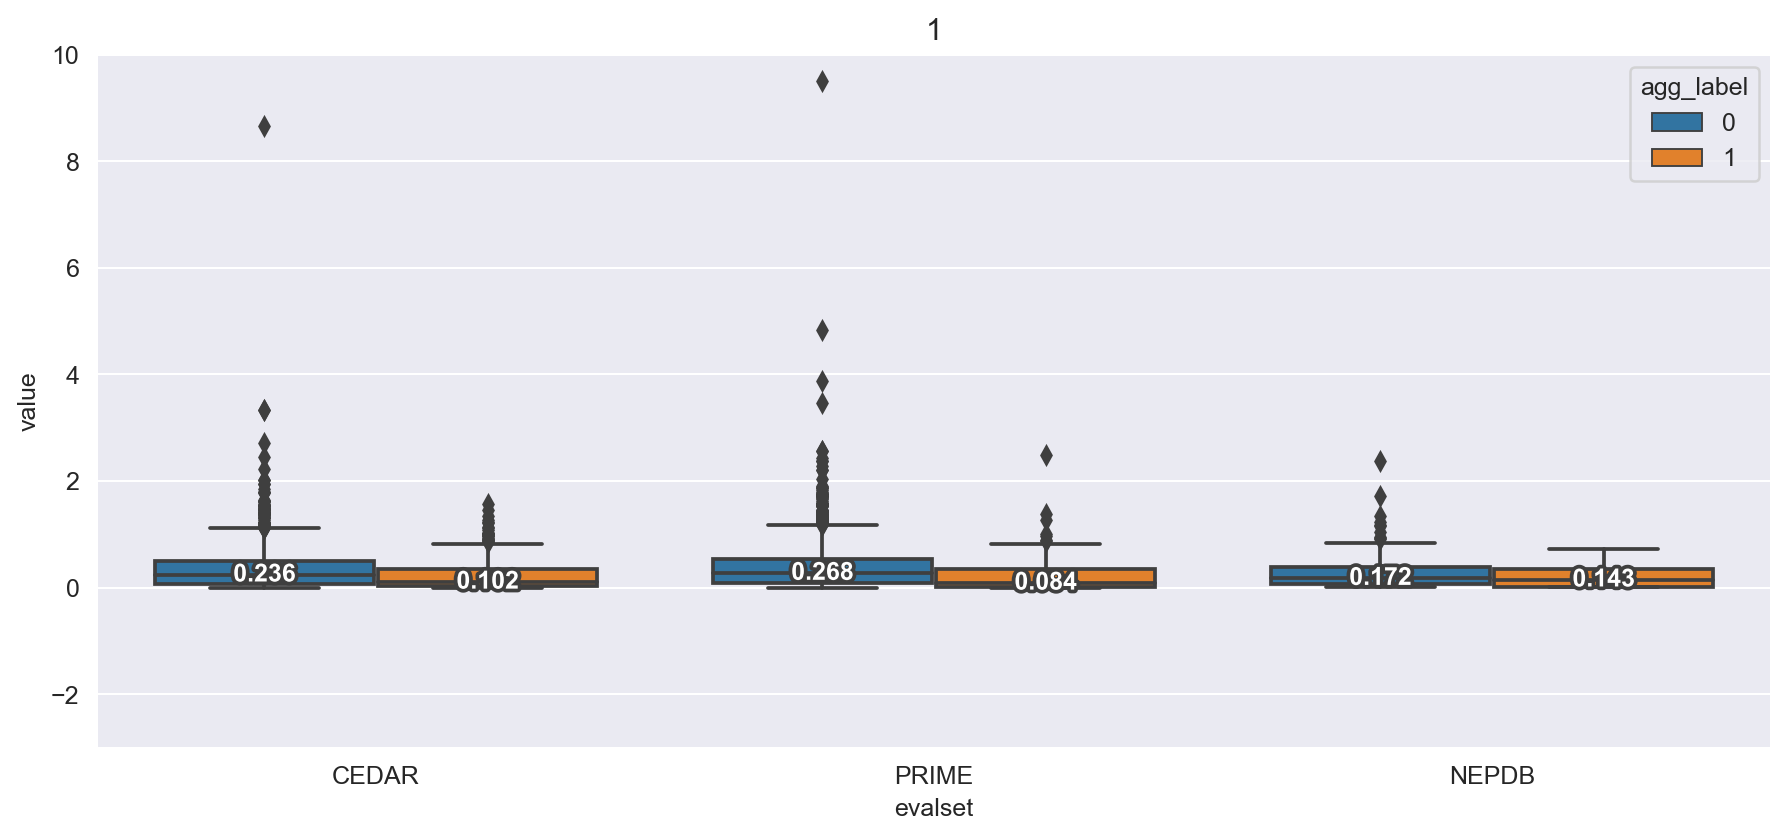

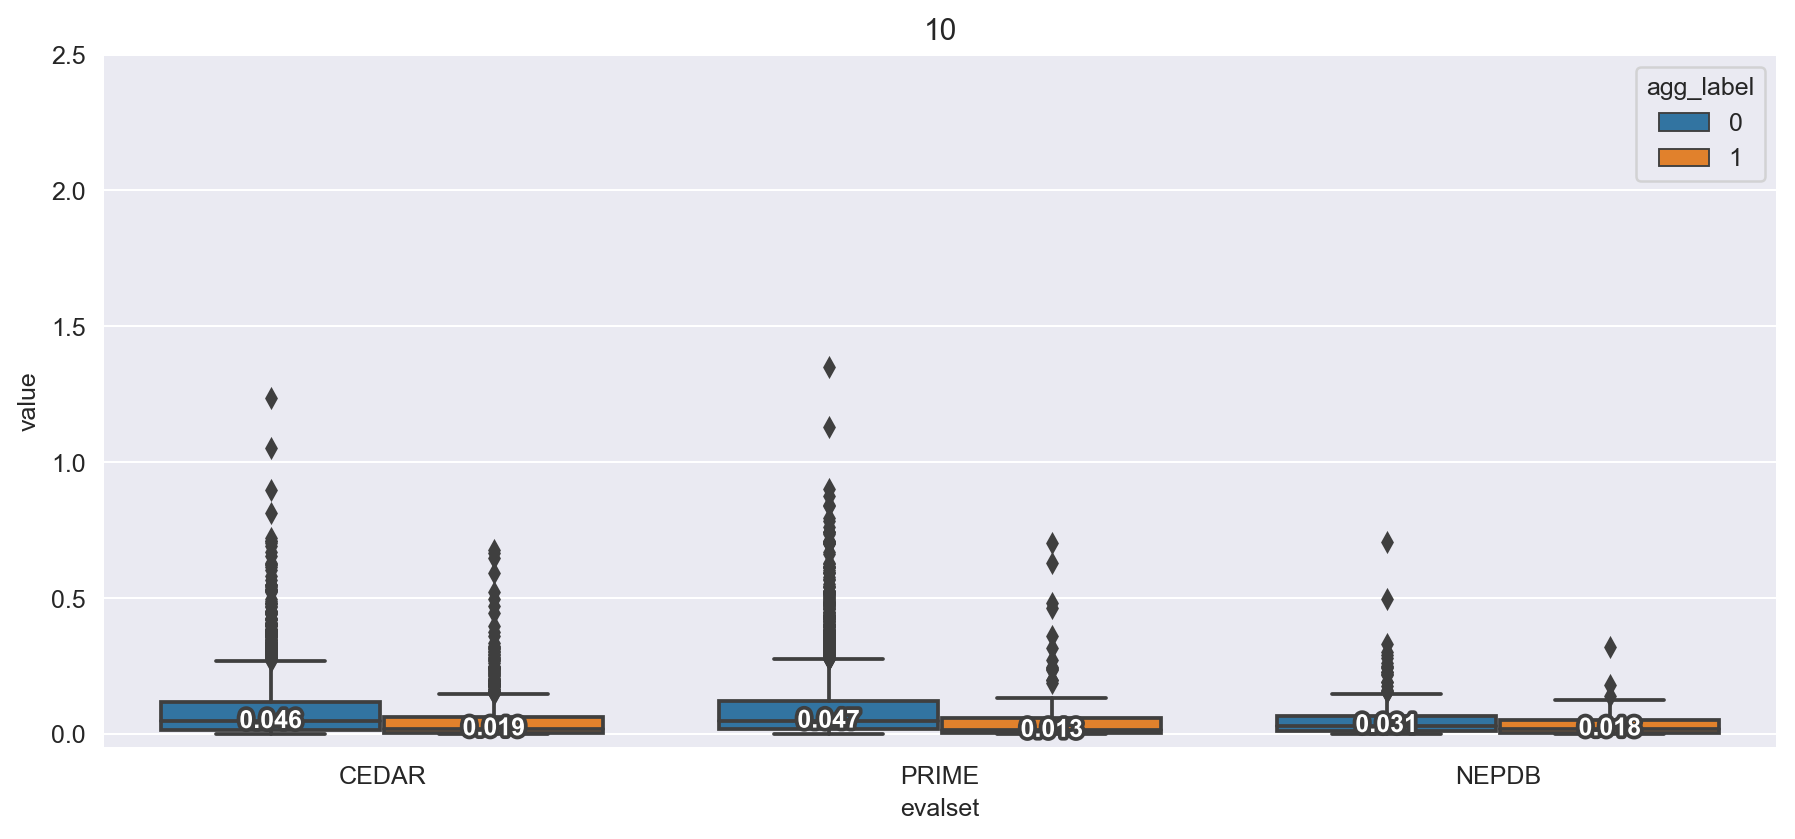

In [116]:
checkcols = ['HLA','agg_label','Peptide','wild_type', 'icore_mut', 'icore_wt_aligned', 'EL_rank_mut', 'EL_rank_wt_aligned', 'ratio_rank']
for alpha in ['None', 'Norm', .01, .1, .5, 1, 10]:
    if alpha =='None':
        cedar_aligned['ratio_rank'] = cedar_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
        prime_aligned['ratio_rank'] = prime_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
        nepdb_aligned['ratio_rank'] = nepdb_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
    elif alpha =='Norm':
        cedar_aligned['ratio_rank'] = cedar_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
        prime_aligned['ratio_rank'] = prime_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
        nepdb_aligned['ratio_rank'] = nepdb_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
    elif type(alpha)==int or type(alpha)==float:
        cedar_aligned['ratio_rank'] = cedar_aligned['EL_rank_mut'] / (cedar_aligned['EL_rank_wt_aligned']+alpha)
        prime_aligned['ratio_rank'] = prime_aligned['EL_rank_mut'] / (prime_aligned['EL_rank_wt_aligned']+alpha)
        nepdb_aligned['ratio_rank'] = nepdb_aligned['EL_rank_mut'] / (nepdb_aligned['EL_rank_wt_aligned']+alpha)
    f,a = plt.subplots(1,1,figsize=(12,5))
    if alpha==10:
        a.set_ylim([-.05, 2.5])
    else:
        a.set_ylim([-3,10])
    tmp = pd.concat([cedar_aligned.melt(id_vars=['Peptide','agg_label'], value_vars=['ratio_rank']).assign(evalset='CEDAR'),
                     prime_aligned.melt(id_vars=['Peptide','agg_label'], value_vars=['ratio_rank']).assign(evalset='PRIME'),
                     nepdb_aligned.melt(id_vars=['Peptide','agg_label'], value_vars=['ratio_rank']).assign(evalset='NEPDB')])
    sns.boxplot(data = tmp, x = 'evalset', hue='agg_label', y='value', ax=a)
    a.set_title(alpha)
    add_median_labels(a, fmt='.3f')

# Retrain / results

In [123]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.bootstrap import bootstrap_eval
from sklearn.ensemble import RandomForestClassifier

odir = '../output/230320_ratioranks/'
for d in [odir, odir+'bootstrapping/', odir+'raw/']:
    os.makedirs(d, exist_ok=True)
    
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                       add_aaprop=False, remove_pep=False, standardize=True, seq_col='icore_mut', 
                       hla_col='HLA', target_col='agg_label', rank_col='EL_rank_mut',
                       mut_col = ['ratio_rank'])

results = []
for alpha in ['None', 'Norm', .01, .1, .5, 1, 10]:
    if alpha =='None':
        cedar_aligned['ratio_rank'] = cedar_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
        prime_aligned['ratio_rank'] = prime_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
        nepdb_aligned['ratio_rank'] = nepdb_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
    elif alpha =='Norm':
        cedar_aligned['ratio_rank'] = cedar_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
        prime_aligned['ratio_rank'] = prime_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
        nepdb_aligned['ratio_rank'] = nepdb_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
    elif type(alpha)==int or type(alpha)==float:
        cedar_aligned['ratio_rank'] = cedar_aligned['EL_rank_mut'] / (cedar_aligned['EL_rank_wt_aligned']+alpha)
        prime_aligned['ratio_rank'] = prime_aligned['EL_rank_mut'] / (prime_aligned['EL_rank_wt_aligned']+alpha)
        nepdb_aligned['ratio_rank'] = nepdb_aligned['EL_rank_mut'] / (nepdb_aligned['EL_rank_wt_aligned']+alpha)
    
    filename = f'onehot_None_icore_mut_EL_rank_mut_GeneralModel_alpha{alpha:0e}' if type(alpha)!=str else f'onehot_None_icore_mut_EL_rank_mut_GeneralModel_alpha{alpha}'
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                           max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                                ics_dict=None,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    fi = get_nested_feature_importance(trained_models)
    fn = AA_KEYS + ['rank'] + ['ratio_rank']
    # Saving Feature importances as dataframe
    df_fi = pd.DataFrame(fi, index=fn).T
    df_fi.to_csv(f'{odir}raw/featimps_{filename}.csv', index=False)
    for evalset, evalname in zip([cedar_aligned, prime_aligned, nepdb_aligned],
                             ['CEDAR', 'PRIME', 'NEPDB']):
        # FULLY FILTERED + Mean_pred
        if not evalset.equals(cedar_aligned):
            evalset = evalset.query('Peptide not in @cedar_aligned.Peptide.values')
        _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                   trained_models, None,
                                                   cedar_aligned,
                                                   encoding_kwargs, concatenated=False,
                                                   only_concat=False)
        p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
        preds.to_csv(f'{odir}raw/{evalname}_preds_{filename}.csv', index=False, columns=checkcols+[p_col])
        
        bootstrapped_df, _ = bootstrap_eval(preds[p_col].values, preds['agg_label'].values, n_jobs=8, auc01=True)
        bootstrapped_df['Model']='General Model'
        bootstrapped_df['Ratio_Alpha'] = alpha
        bootstrapped_df['evalset'] = evalname
        bootstrapped_df.to_csv(f'{odir}bootstrapping/{evalname}_bootstrapped_df_{filename}.csv')
        results.append(bootstrapped_df)

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [124]:
pd.concat(results).to_csv(odir+'total_df_onlyRatioRank.csv', index=False)

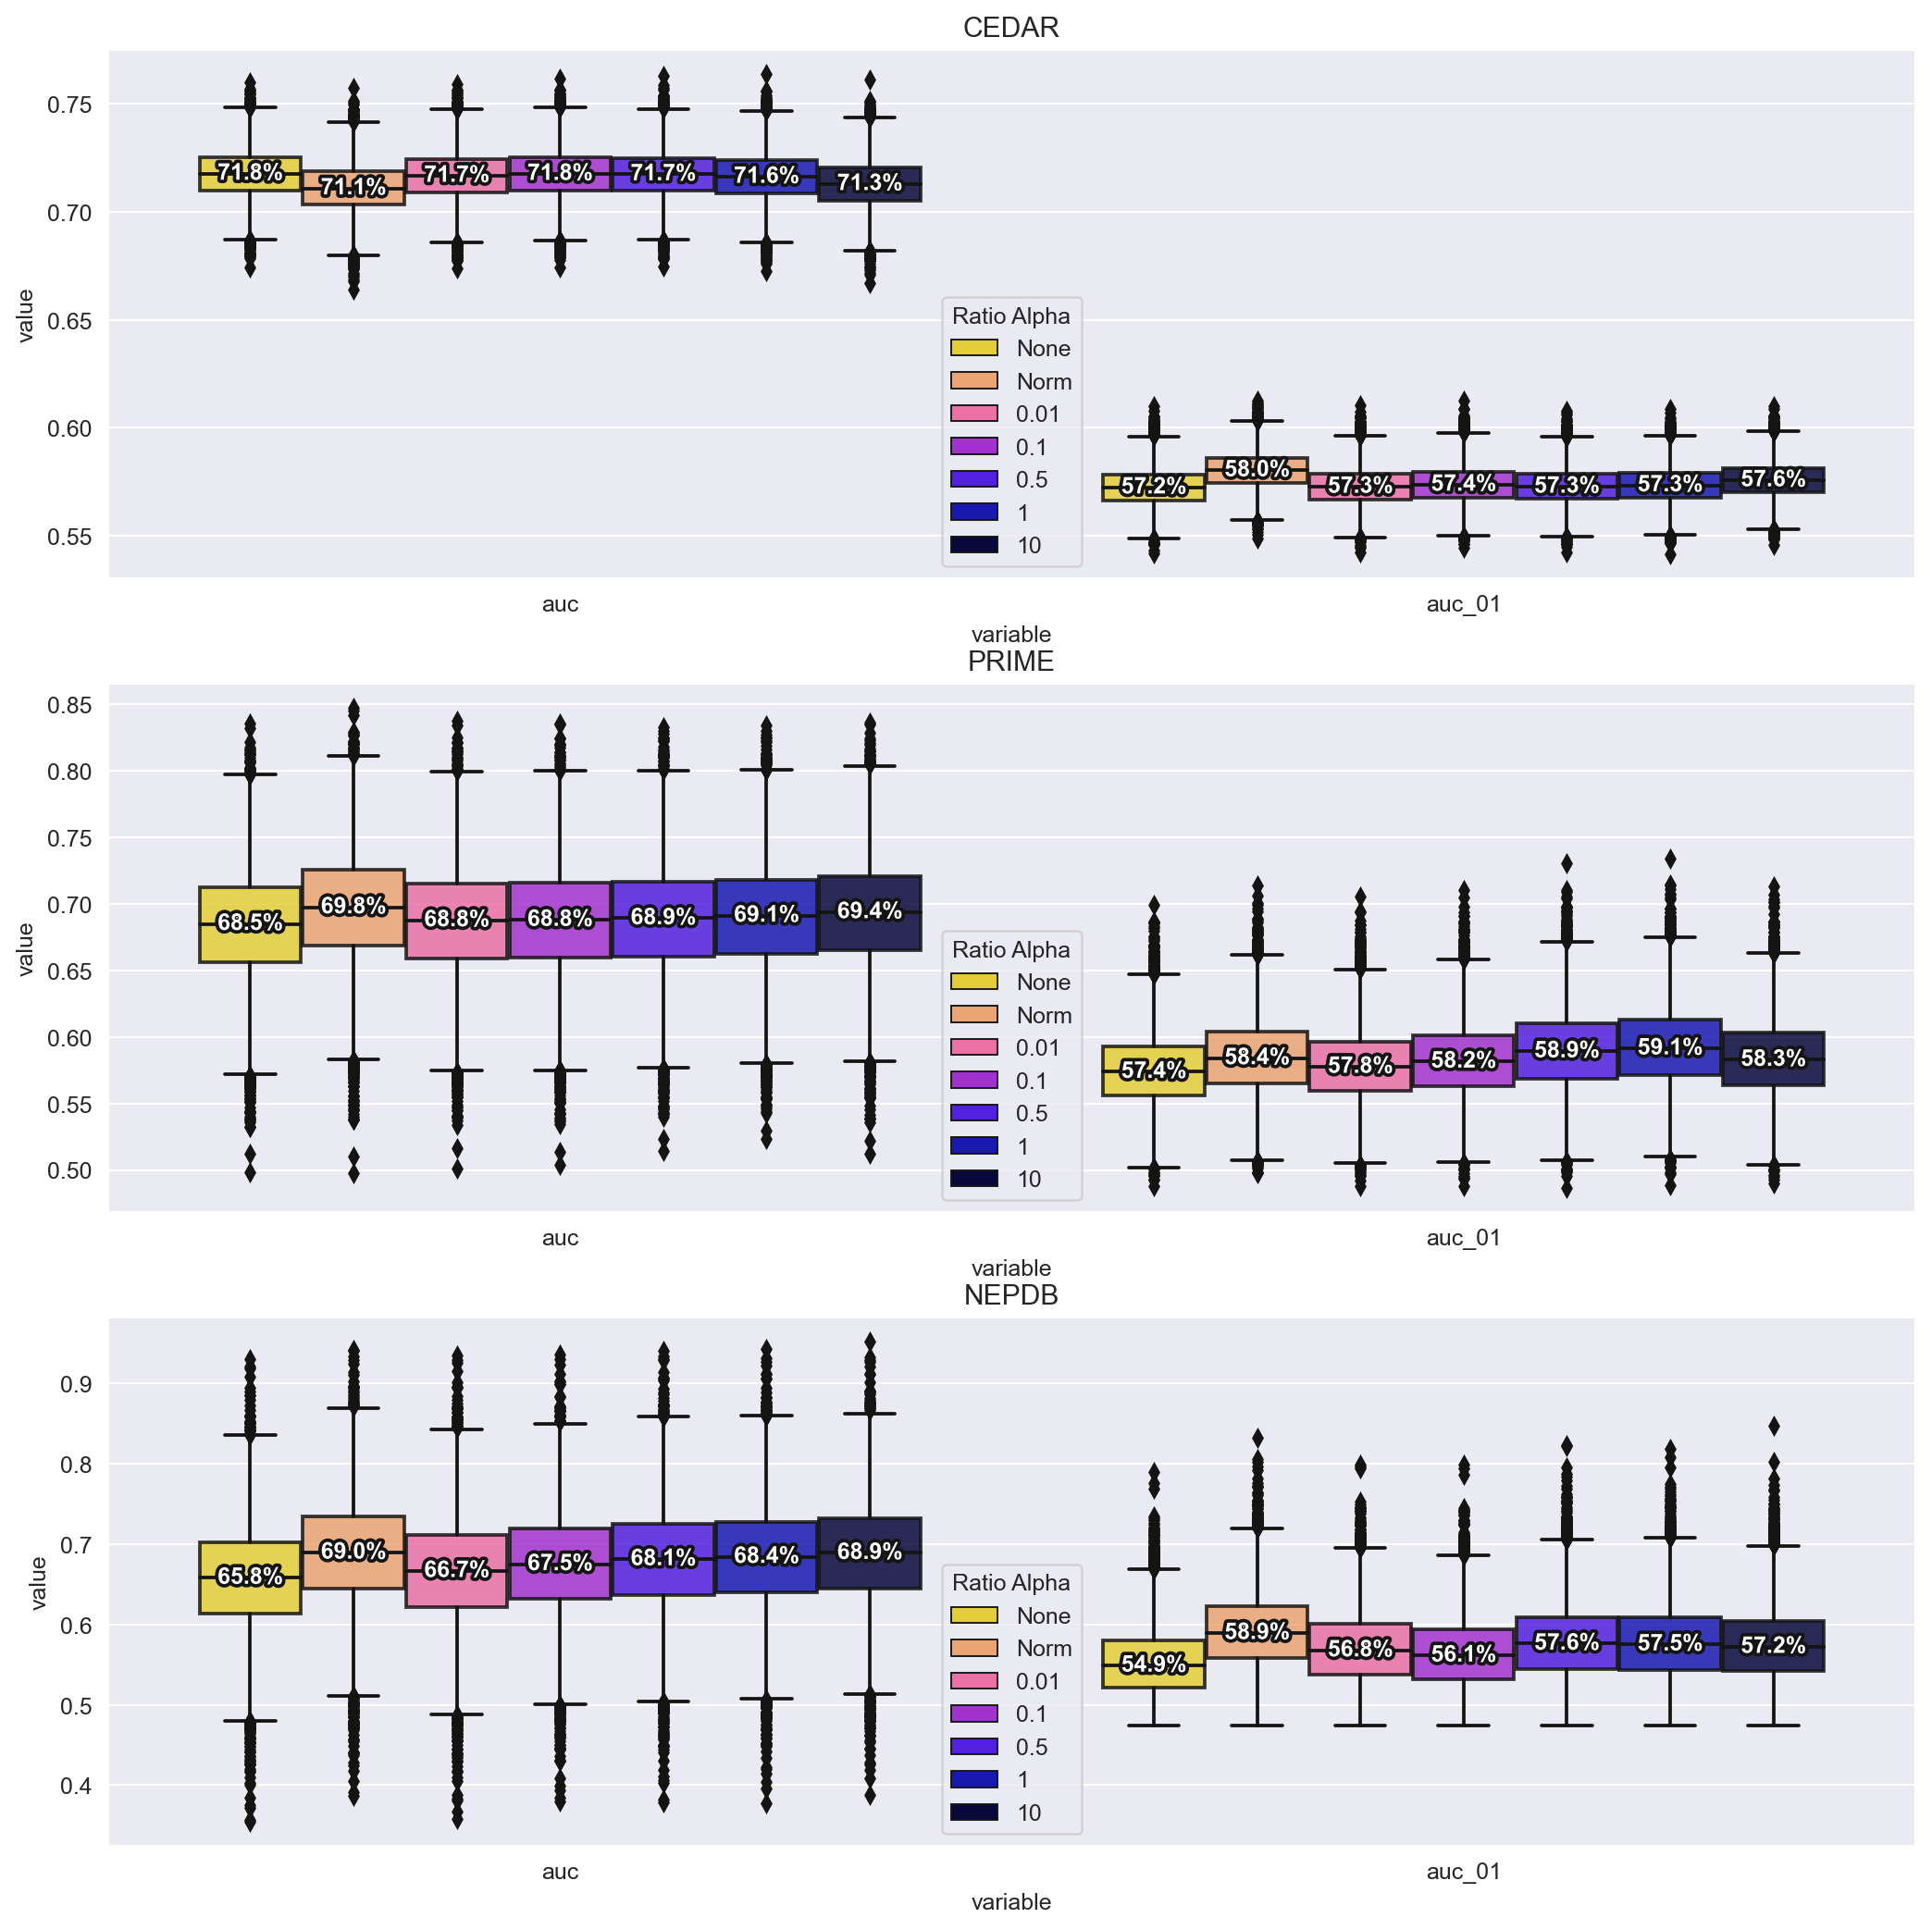

In [125]:
# THIS PLOT WAS MADE WITH only RATIO RANK
total_df=pd.concat(results)

f,a = plt.subplots(3,1, figsize=(14,14))

for evalset, axis in zip(total_df.evalset.unique(), a.ravel()):
    sns.boxplot(data= total_df.query('evalset==@evalset').melt(id_vars=['Ratio_Alpha'], value_vars =['auc', 'auc_01']), 
                palette = get_palette('gnuplot2_r', n_colors=7), x='variable', y='value', hue='Ratio_Alpha', ax = axis)
    axis.set_title(evalset)
    axis.legend(loc='lower center', title='Ratio Alpha')
    add_median_labels(axis)
    plt.setp(axis.patches, alpha=0.85)

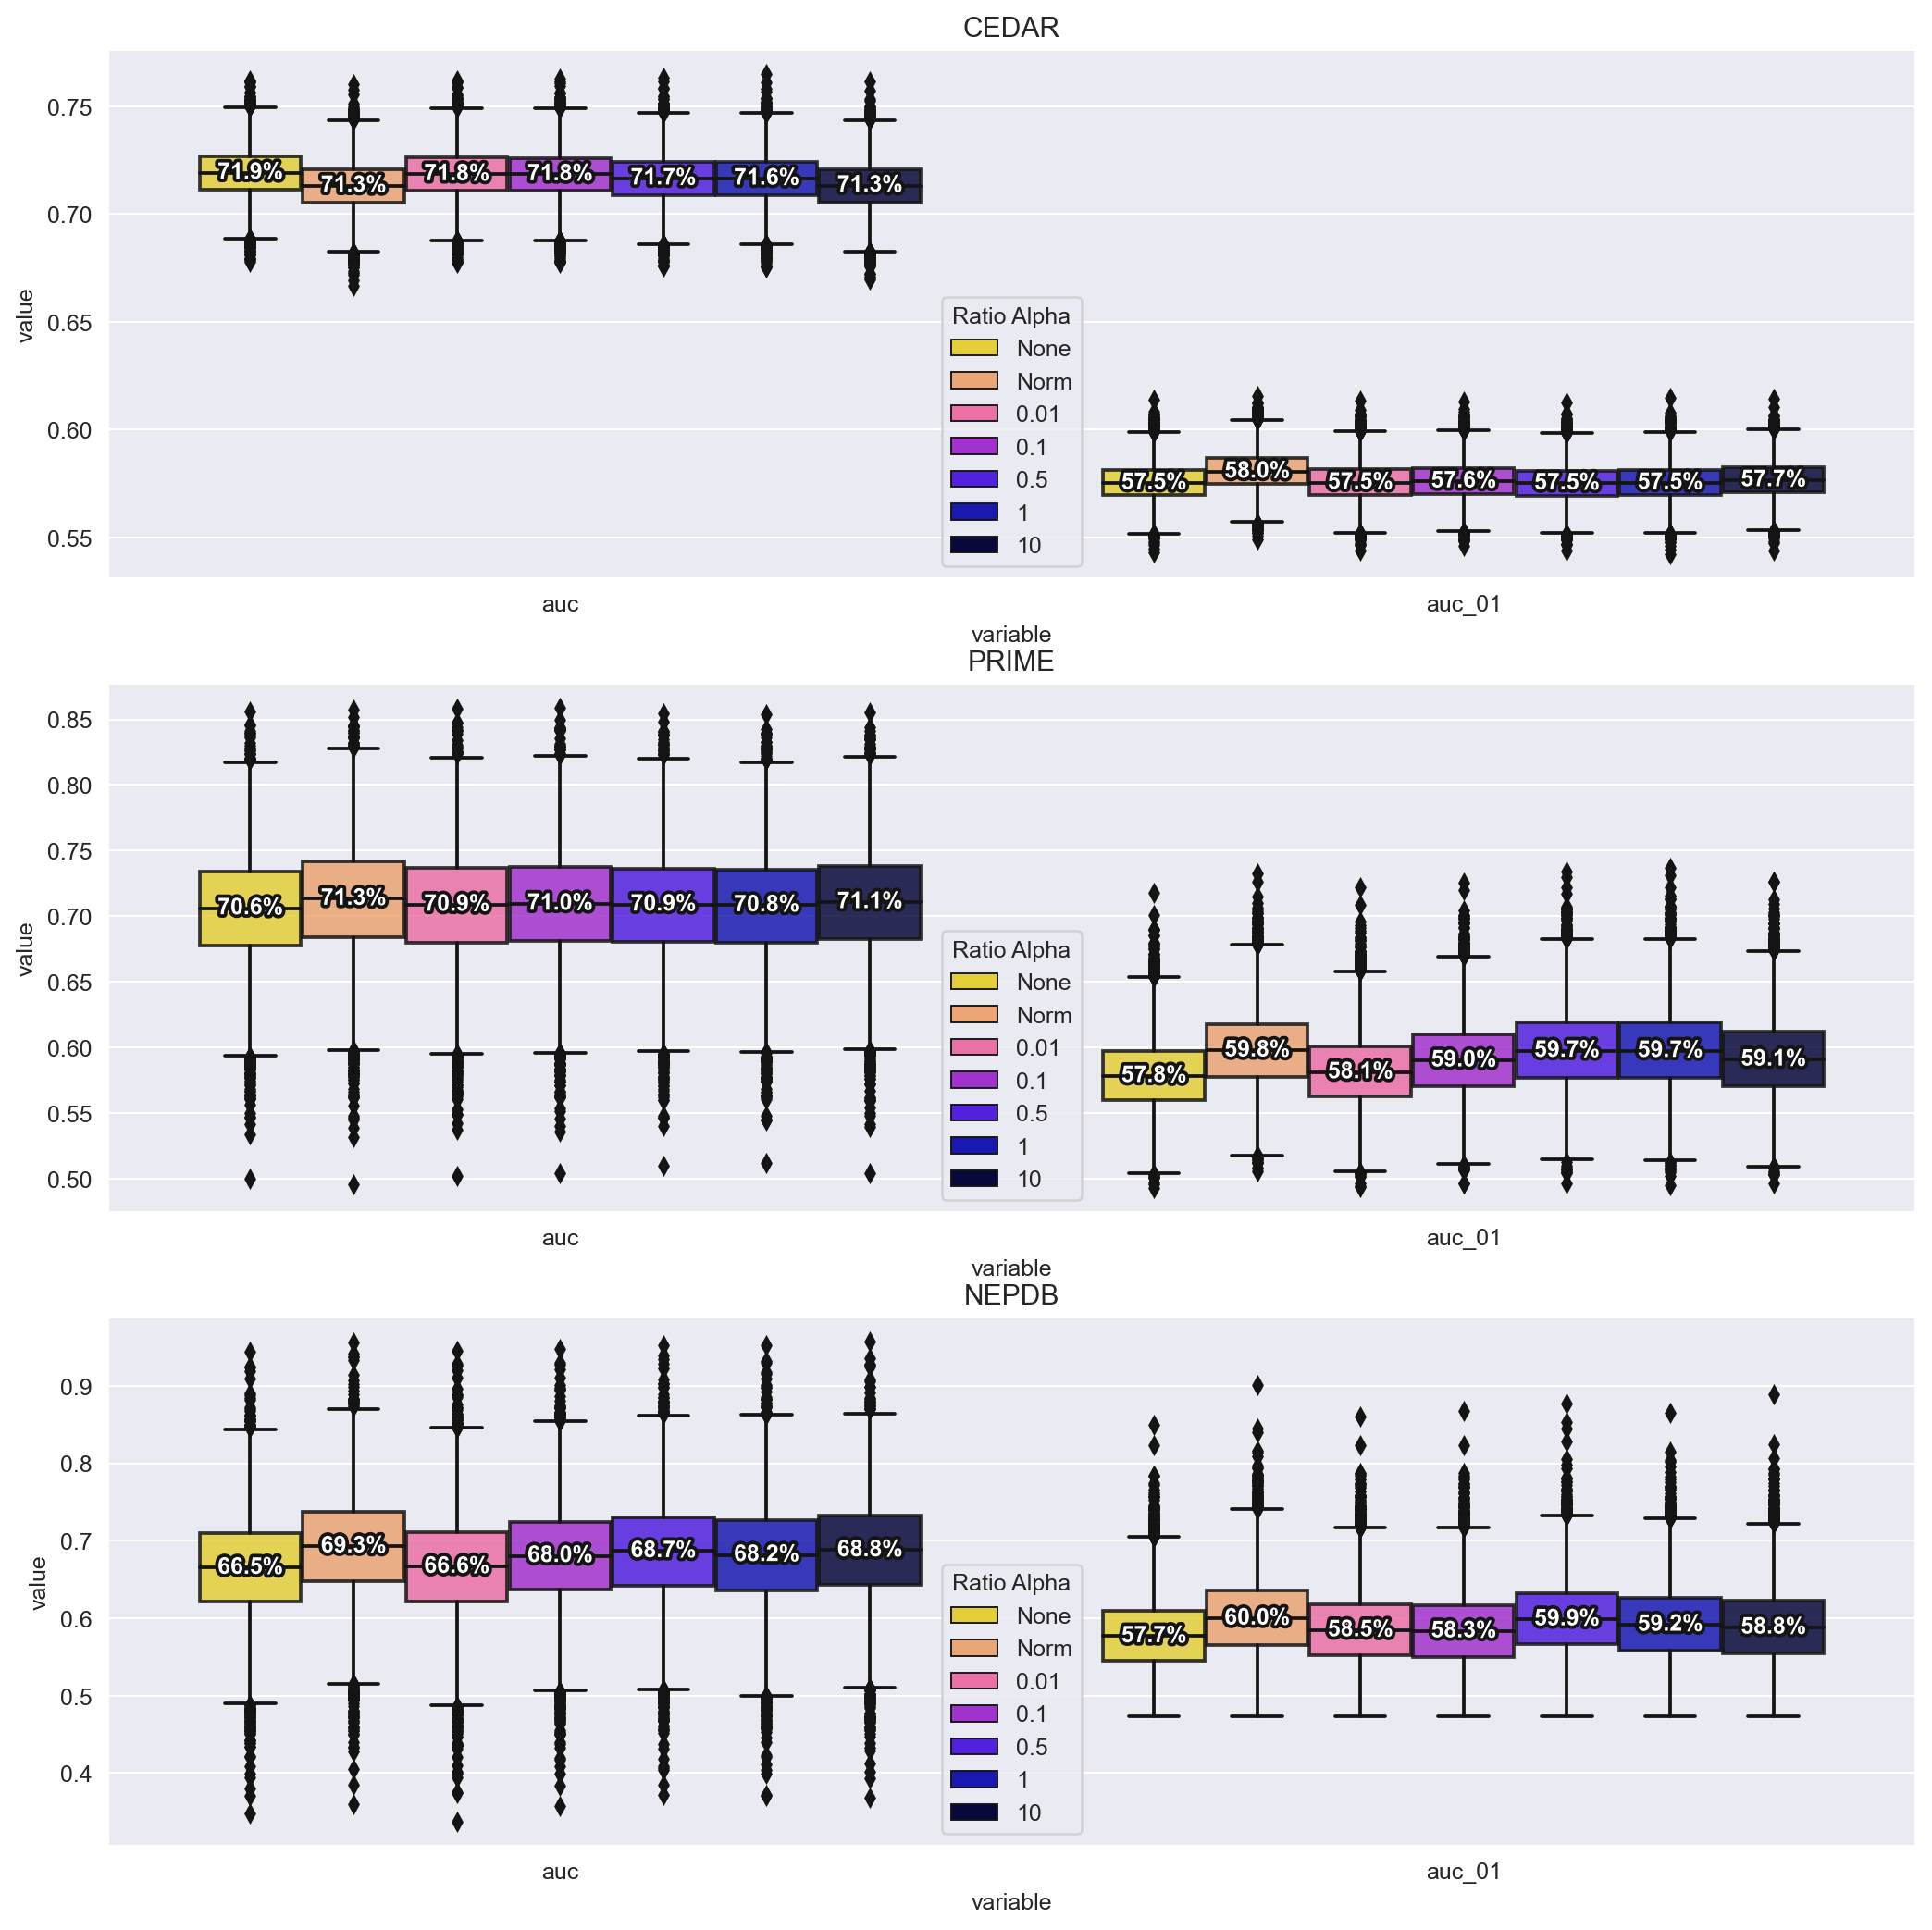

In [108]:
# THIS PLOT WAS MADE WITH ICORE_DISS SCORE + ICORE_BLSM SCORE + RATIO RANK

total_df=pd.read_csv(odir+'total_df.csv')

f,a = plt.subplots(3,1, figsize=(14,14))

for evalset, axis in zip(total_df.evalset.unique(), a.ravel()):
    sns.boxplot(data= total_df.query('evalset==@evalset').melt(id_vars=['Ratio_Alpha'], value_vars =['auc', 'auc_01']), 
                palette = get_palette('gnuplot2_r', n_colors=7), x='variable', y='value', hue='Ratio_Alpha', ax = axis)
    axis.set_title(evalset)
    axis.legend(loc='lower center', title='Ratio Alpha')
    add_median_labels(axis)
    plt.setp(axis.patches, alpha=0.85)

# Redo best models with ratio-rank * norm

In [262]:
def final_bootstrap_wrapper(preds_df, filename,
                            ic_name, condition_name, ratio, key, evalset,
                            n_rounds=10000, n_jobs=8, outdir='./'):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'icore_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['condition'] = condition_name
    bootstrapped_df['ratio'] = ratio
    bootstrapped_df['evalset'] = evalset.upper()

    bootstrapped_df.to_csv(
        f'{outdir}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
        index=False)
    pkl_dump(mean_rocs,
             f'{outdir}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

In [129]:
cedar_aligned_expr['ratio_rank'] = cedar_aligned_expr.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
prime_aligned_expr['ratio_rank'] = prime_aligned_expr.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
nepdb_aligned_expr['ratio_rank'] = nepdb_aligned_expr.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)

In [263]:
from src.utils import mkdirs, pkl_dump
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.metrics import get_nested_feature_importance

# Here, do comparison of adding new ratio rank vs not doing anything, using the top 3 models
# Condition = [ic_name, ic_dict, mut_cols]
outdir_ratio = '../output/230328_AllModels_AddRatio/'
mkdirs(outdir_ratio)
mkdirs(outdir_ratio+'bootstrapping/')
mkdirs(outdir_ratio+'raw/')
###
cedar_dataset = cedar_aligned_expr
prime_dataset = prime_aligned_expr
nepdb_dataset = nepdb_aligned_expr
train_dataset = cedar_dataset

###
cdt_cedar = ['Inverted-Shannon', ics_shannon, 'aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM'.split('-')]
cdt_prime = ['Mask', ics_shannon, 'icore_dissimilarity_score-icore_blsm_mut_score'.split('-')]
cdt_gen = ['None', None, 'icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM'.split('-')]
cdt_base = ['None', None, None]
mega_df = pd.DataFrame()

for (ic_name, ics_dict, mut_cols), condition_name in zip([cdt_cedar, cdt_prime, cdt_gen, cdt_base],
                                     ['OptCedar','OptPrime','General','Base']):
    for ratio in ['NoRatio', 'OldRatio', 'NormRatio']:
        if ratio == 'NoRatio':
            add_ratio = False
        elif ratio == 'OldRatio':
            add_ratio = True
            cedar_dataset['ratio_rank'] = cedar_dataset.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            prime_dataset['ratio_rank'] = prime_dataset.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            nepdb_dataset['ratio_rank'] = nepdb_dataset.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            
        elif ratio == 'NormRatio':
            add_ratio = True
            cedar_dataset['ratio_rank'] = cedar_dataset.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            prime_dataset['ratio_rank'] = prime_dataset.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            nepdb_dataset['ratio_rank'] = nepdb_dataset.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            
        if mut_cols is None:
            mc = ['ratio_rank'] if add_ratio else None
        else:
            mc = mut_cols + ['ratio_rank'] if add_ratio else mut_cols
        
        seqcol = 'Peptide' if condition_name == "Base" else 'icore_mut'
        rankcol = 'trueHLA_EL_rank' if condition_name == "Base" else 'EL_rank_mut'
        
        encoding_kwargs = dict(max_len=12, encoding='onehot', rank_col=rankcol, seq_col=seqcol,
                           blosum_matrix=None, add_rank=True, add_aaprop=False, mut_col = mc,
                           remove_pep=False, standardize=True, invert = ('Inverted' in ic_name), mask = ('Mask' in ic_name))
        
        key = '-'.join(mc) if mc is not None else 'only_rank'
        key = key.replace('aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8', 'aa_props')
        key = key.replace(' ', '-')
        print(add_ratio, mc, '\n', key)
        filename = f'onehot_{"-".join(ic_name.split(" "))}_icore_mut_EL_rank_mut_{condition_name}_{ratio}_{key}'
        # Using the same model and hyperparameters
        model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                       max_depth=8, ccp_alpha=9.945e-6)
        # Training model and getting feature importances
        print('Training')
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                    ics_dict=ics_dict,
                                                                    encoding_kwargs=encoding_kwargs,
                                                                    n_jobs=8)
        fi = get_nested_feature_importance(trained_models)
        fn = AA_KEYS + ['rank'] if mc is None else AA_KEYS+['rank'] + mc
        # Saving Feature importances as dataframe
        df_fi = pd.DataFrame(fi, index=fn).T
        df_fi.to_csv(
            f'{outdir_ratio}raw/featimps_{filename}.csv',
            index=False)
    
        for evalset, evalname in zip([cedar_dataset, prime_dataset, nepdb_dataset],
                                     ['CEDAR', 'PRIME', 'NEPDB']):
            # FULLY FILTERED + Mean_pred
            if not evalset.equals(train_dataset):
                evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
            _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                       trained_models, ics_dict,
                                                       train_dataset,
                                                       encoding_kwargs, concatenated=False,
                                                       only_concat=True, n_jobs=8)
            p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
            preds.to_csv(f'{outdir_ratio}raw/{evalname}_preds_{filename}.csv', index=False, columns = [p_col, 'Peptide', 'icore_mut', 'EL_rank_mut', 'EL_rank_wt_aligned', 'ratio_rank', 'foreignness_score', 'agg_label', 'HLA'])
    
            bootstrapped_df = final_bootstrap_wrapper(preds, filename, ic_name, condition_name, ratio,
                                                      key, evalname, n_rounds=10000, n_jobs = 8,outdir=outdir_ratio)
        del trained_models, bootstrapped_df

False ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'EL_rank_wt_aligned', 'Total_Gene_TPM'] 
 aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NoRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NoRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NoRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.
True ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'EL_rank_wt_aligned', 'Total_Gene_TPM', 'ratio_rank'] 
 aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_OldRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_OldRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_OldRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank.pkl saved.
True ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'EL_rank_wt_aligned', 'Total_Gene_TPM', 'ratio_rank'] 
 aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NormRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NormRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NormRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank.pkl saved.
False ['icore_dissimilarity_score', 'icore_blsm_mut_score'] 
 icore_dissimilarity_score-icore_blsm_mut_score
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.
True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank'] 
 icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_OldRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_OldRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_OldRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.
True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank'] 
 icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.
False ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM'] 
 icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM.pkl saved.
True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM', 'ratio_rank'] 
 icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_OldRatio_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_OldRatio_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_OldRatio_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.
True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM', 'ratio_rank'] 
 icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.
False None 
 only_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NoRatio_only_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NoRatio_only_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NoRatio_only_rank.pkl saved.
True ['ratio_rank'] 
 ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_OldRatio_ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_OldRatio_ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_OldRatio_ratio_rank.pkl saved.
True ['ratio_rank'] 
 ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NormRatio_ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NormRatio_ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_AllModels_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NormRatio_ratio_rank.pkl saved.


In [264]:
total_df = pd.concat([pd.read_csv(outdir_ratio+'bootstrapping/'+x) for x in os.listdir(outdir_ratio+'bootstrapping/') if x.endswith('csv')])

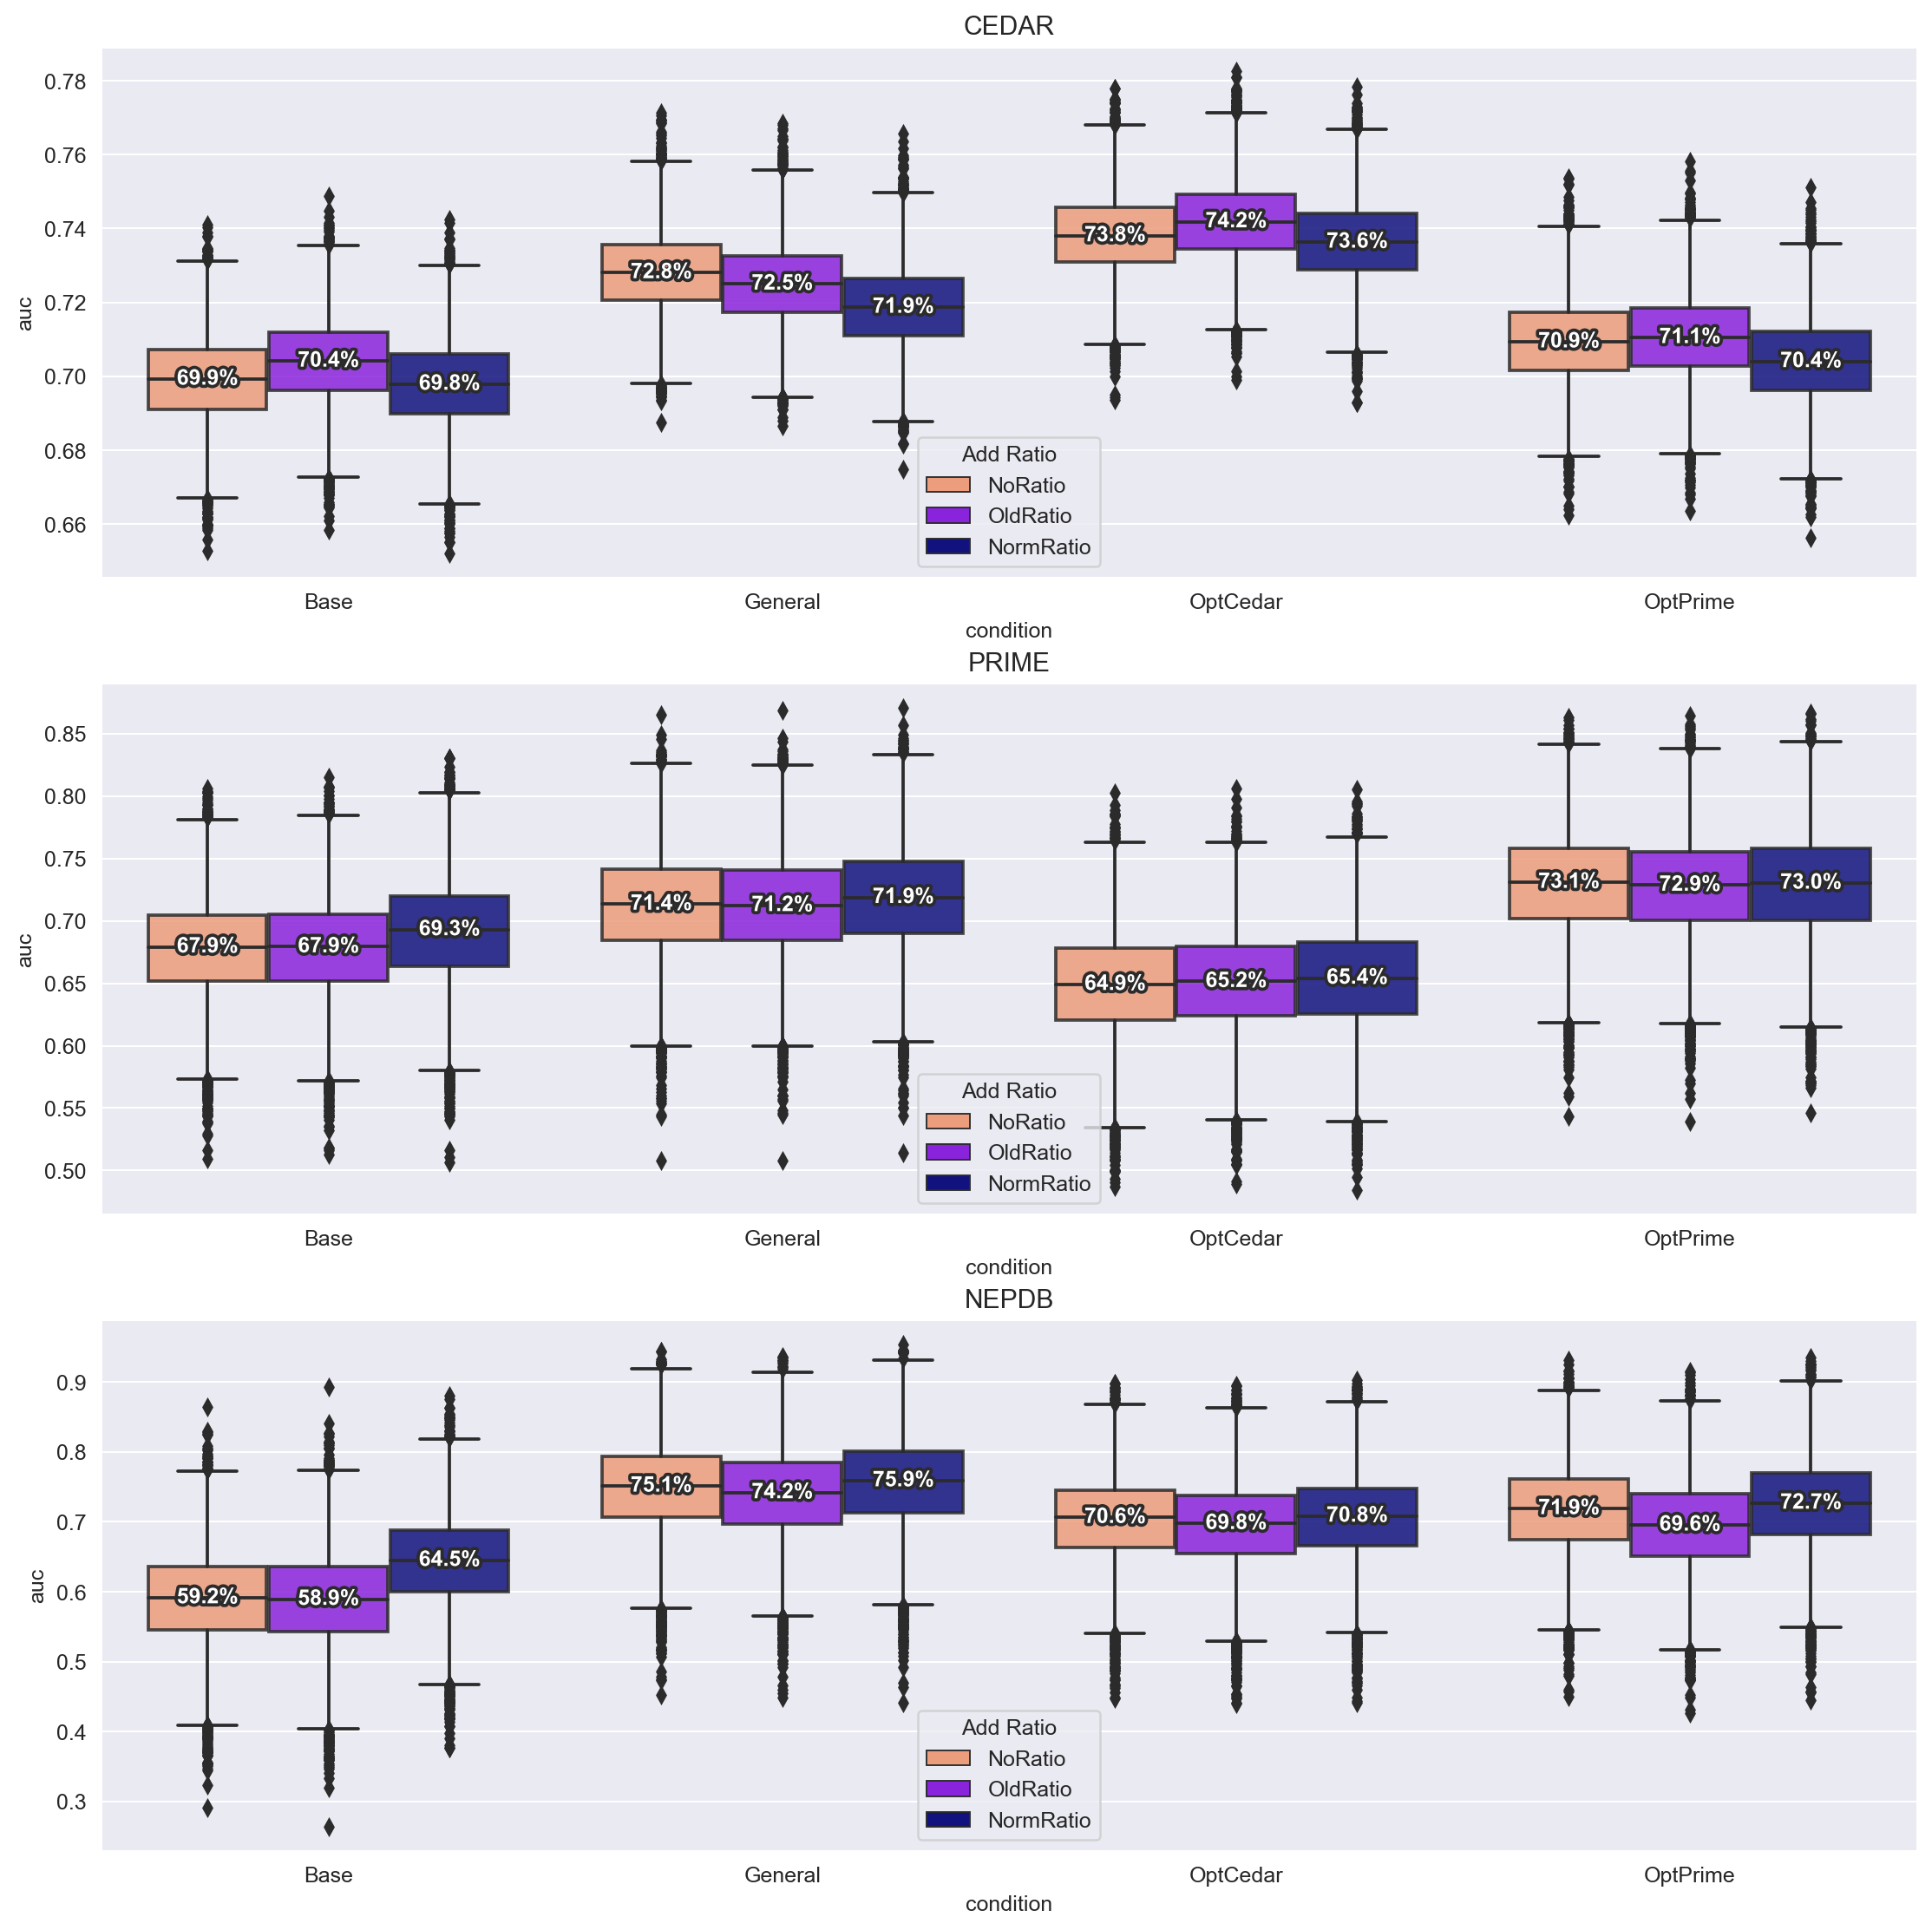

In [265]:
f,a = plt.subplots(3,1, figsize=(15,15))
sns.set_palette(get_palette('gnuplot2_r', 3))
order = ['Base', 'General', 'OptCedar', 'OptPrime']
hue_order = ['NoRatio', 'OldRatio', 'NormRatio']

for evalset, axis in zip(['CEDAR', 'PRIME', 'NEPDB'], a.ravel()):
    axis.set_title(evalset)
    sns.boxplot(data=total_df.query('evalset==@evalset'), order = order,hue_order=hue_order,
                y = 'auc', x='condition', hue='ratio', ax=axis)
    add_median_labels(axis)
    axis.legend(title='Add Ratio', loc='lower center')
    plt.setp(axis.patches, alpha = 0.85)

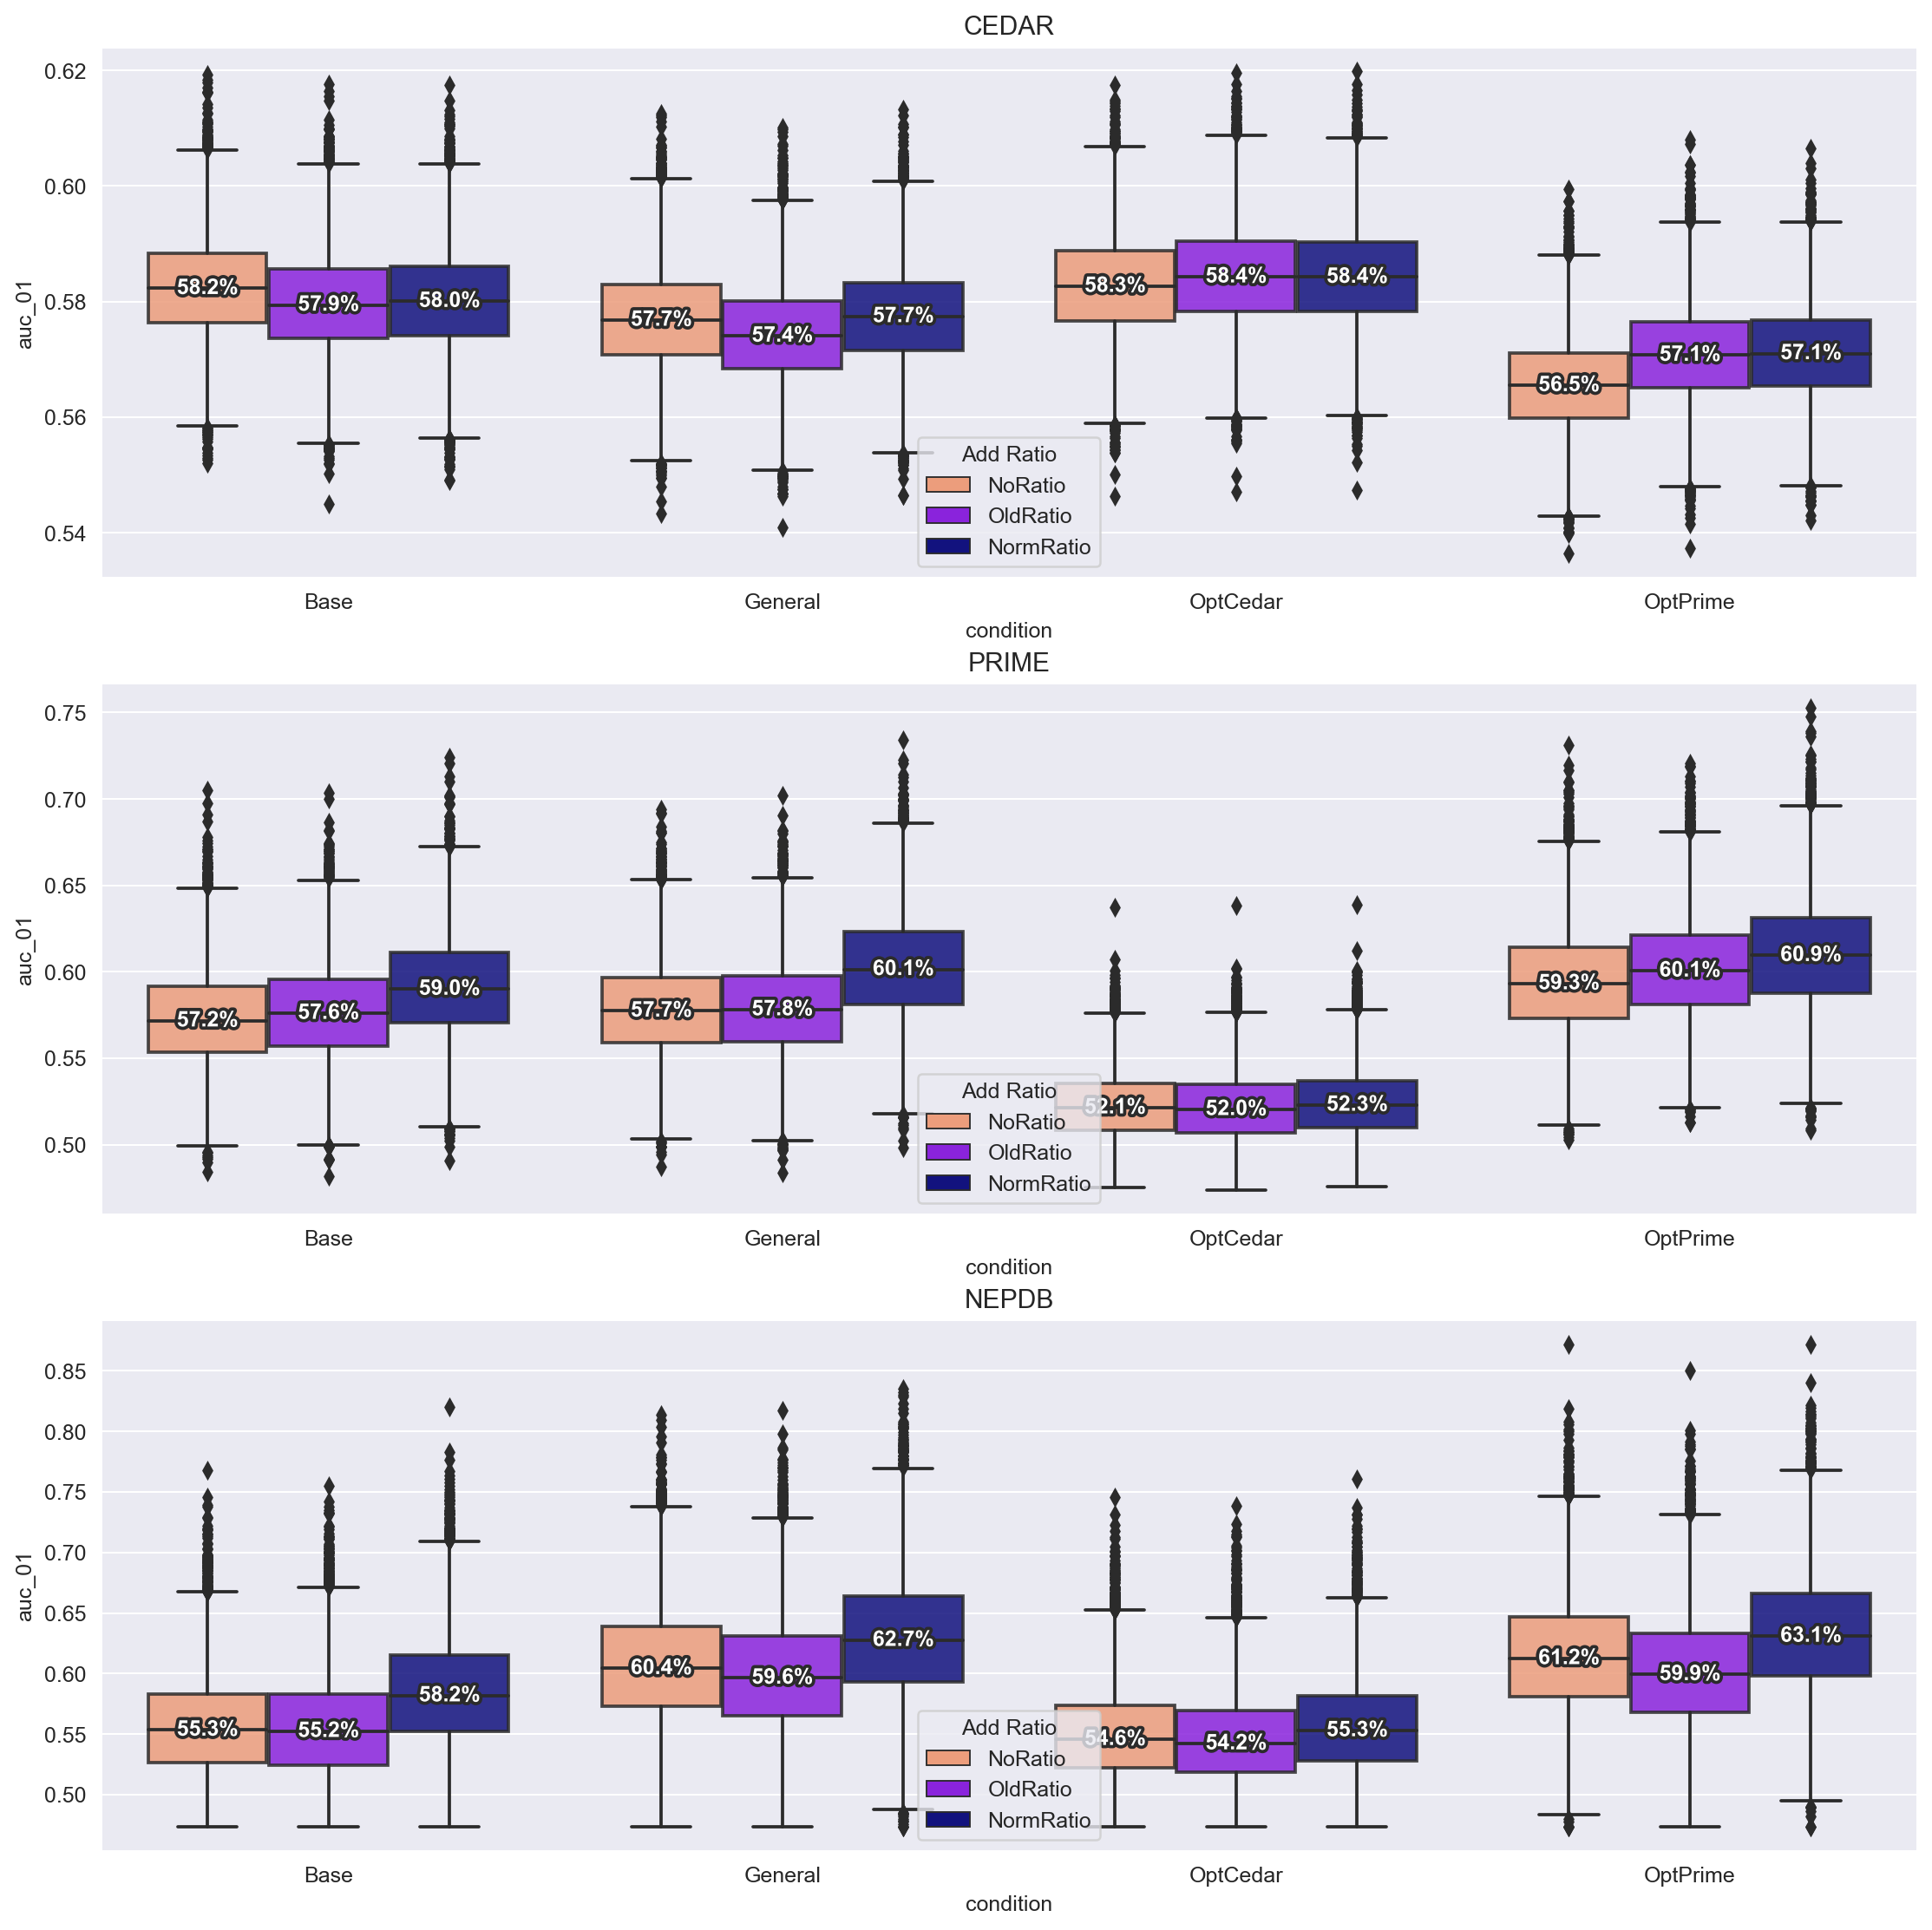

In [199]:
f,a = plt.subplots(3,1, figsize=(15,15))
sns.set_palette(get_palette('gnuplot2_r', 3))
order = ['Base', 'General', 'OptCedar', 'OptPrime']
hue_order = ['NoRatio', 'OldRatio', 'NormRatio']
for evalset, axis in zip(['CEDAR', 'PRIME', 'NEPDB'], a.ravel()):
    axis.set_title(evalset)
    sns.boxplot(data=total_df.query('evalset==@evalset'), order = order, hue_order=hue_order,
                y = 'auc_01', x='condition', hue='ratio', ax=axis)
    add_median_labels(axis)
    axis.legend(title='Add Ratio', loc='lower center')
    plt.setp(axis.patches, alpha = 0.85)

# Redo all but using the aligned dataset

See performance and update Analysis 5 accordingly

In [235]:
def final_bootstrap_wrapper(preds_df, filename,
                            ic_name, condition_name, ratio, key, evalset,
                            n_rounds=10000, n_jobs=8, outdir = './'):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'icore_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['condition'] = condition_name
    bootstrapped_df['ratio'] = ratio
    bootstrapped_df['evalset'] = evalset.upper()

    bootstrapped_df.to_csv(
        f'{outdir}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
        index=False)
    pkl_dump(mean_rocs,
             f'{outdir}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

In [227]:
cedar_aligned['ratio_rank'] = cedar_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
prime_aligned['ratio_rank'] = prime_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
nepdb_aligned['ratio_rank'] = nepdb_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)

In [234]:
%ls ../output/230328_Aligned_AddRatio/bootstrapping/

In [245]:
from src.utils import mkdirs, pkl_dump
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.metrics import get_nested_feature_importance

# Here, do comparison of adding new ratio rank vs not doing anything, using the top 3 models
# Condition = [ic_name, ic_dict, mut_cols]
outdir_ratio_aligned = '../output/230328_Aligned_AddRatio/'
mkdirs(outdir_ratio_aligned)
mkdirs(outdir_ratio_aligned+'bootstrapping/')
mkdirs(outdir_ratio_aligned+'raw/')
###
cedar_dataset = cedar_aligned
prime_dataset = prime_aligned
nepdb_dataset = nepdb_aligned
train_dataset = cedar_dataset

###
cdt_cedar = ['Inverted-Shannon', ics_shannon, 'aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-EL_rank_wt_aligned'.split('-')]
cdt_prime = ['Mask', ics_shannon, 'icore_dissimilarity_score-icore_blsm_mut_score'.split('-')]
cdt_gen = ['None', None, 'icore_dissimilarity_score-icore_blsm_mut_score'.split('-')]
cdt_base = ['None', None, None]
mega_df = pd.DataFrame()

for (ic_name, ics_dict, mut_cols), condition_name in zip([cdt_cedar, cdt_prime, cdt_gen, cdt_base],
                                     ['OptCedar','OptPrime','General','Base']):
    for ratio in ['NormRatio', 'NoRatio']:
        if ratio == 'NoRatio':
            add_ratio = False
        elif ratio == 'OldRatio':
            add_ratio = True
            cedar_dataset['ratio_rank'] = cedar_dataset.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            prime_dataset['ratio_rank'] = prime_dataset.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            nepdb_dataset['ratio_rank'] = nepdb_dataset.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            
        elif ratio == 'NormRatio':
            add_ratio = True
            cedar_dataset['ratio_rank'] = cedar_dataset.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            prime_dataset['ratio_rank'] = prime_dataset.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            nepdb_dataset['ratio_rank'] = nepdb_dataset.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            
        if mut_cols is None:
            mc = ['ratio_rank'] if add_ratio else None
        else:
            mc = mut_cols + ['ratio_rank'] if add_ratio else mut_cols
        
        seqcol = 'Peptide' if condition_name == "Base" else 'icore_mut'
        rankcol = 'trueHLA_EL_rank' if condition_name == "Base" else 'EL_rank_mut'
        
        encoding_kwargs = dict(max_len=12, encoding='onehot', rank_col=rankcol, seq_col=seqcol,
                           blosum_matrix=None, add_rank=True, add_aaprop=False, mut_col = mc,
                           remove_pep=False, standardize=True, invert = ('Inverted' in ic_name), mask = ('Mask' in ic_name))
        
        key = '-'.join(mc) if mc is not None else 'only_rank'
        key = key.replace('aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8', 'aa_props')
        key = key.replace(' ', '-')
        print(add_ratio, mc, '\n', key)
        filename = f'onehot_{"-".join(ic_name.split(" "))}_icore_mut_EL_rank_mut_{condition_name}_{ratio}_{key}'
        # Using the same model and hyperparameters
        model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                       max_depth=8, ccp_alpha=9.945e-6)
        # Training model and getting feature importances
        print('Training')
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                    ics_dict=ics_dict,
                                                                    encoding_kwargs=encoding_kwargs,
                                                                    n_jobs=8)
        fi = get_nested_feature_importance(trained_models)
        fn = AA_KEYS + ['rank'] if mc is None else AA_KEYS+['rank'] + mc
        # Saving Feature importances as dataframe
        df_fi = pd.DataFrame(fi, index=fn).T
        df_fi.to_csv(
            f'{outdir_ratio_aligned}raw/featimps_{filename}.csv',
            index=False)
    
        for evalset, evalname in zip([cedar_dataset, prime_dataset, nepdb_dataset],
                                     ['CEDAR', 'PRIME', 'NEPDB']):
            # FULLY FILTERED + Mean_pred
            if not evalset.equals(train_dataset):
                evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
            _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                       trained_models, ics_dict,
                                                       train_dataset,
                                                       encoding_kwargs, concatenated=False,
                                                       only_concat=True, n_jobs=8)
            p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
            preds.to_csv(f'{outdir_ratio_aligned}raw/{evalname}_preds_{filename}.csv', index=False, 
                         columns = [x for x in [p_col, 'Peptide', 'icore_mut', 'EL_rank_mut', 'EL_rank_wt_aligned', 'ratio_rank', 'foreignness_score', 'agg_label', 'HLA']\
                                    if x in preds.columns])
    
            bootstrapped_df = final_bootstrap_wrapper(preds, filename, ic_name, condition_name, ratio,
                                                      key, evalname, n_rounds=10000, n_jobs = 8, outdir=outdir_ratio_aligned)
        del trained_models, bootstrapped_df

True ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'EL_rank_wt_aligned', 'ratio_rank'] 
 aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NormRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NormRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NormRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-ratio_rank.pkl saved.
False ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'EL_rank_wt_aligned'] 
 aa_props-icore_dissimilarity_score-EL_rank_wt_aligned
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NoRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NoRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_NoRatio_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned.pkl saved.
True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank'] 
 icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.
False ['icore_dissimilarity_score', 'icore_blsm_mut_score'] 
 icore_dissimilarity_score-icore_blsm_mut_score
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.
True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank'] 
 icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NormRatio_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.
False ['icore_dissimilarity_score', 'icore_blsm_mut_score'] 
 icore_dissimilarity_score-icore_blsm_mut_score
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_NoRatio_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.
True ['ratio_rank'] 
 ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NormRatio_ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NormRatio_ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NormRatio_ratio_rank.pkl saved.
False None 
 only_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NoRatio_only_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NoRatio_only_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230328_Aligned_AddRatio/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_NoRatio_only_rank.pkl saved.


In [249]:
aligned_df = pd.concat([pd.read_csv(outdir_ratio_aligned+'bootstrapping/'+x) \
                      for x in os.listdir(outdir_ratio_aligned+'bootstrapping/') if x.endswith('csv')])



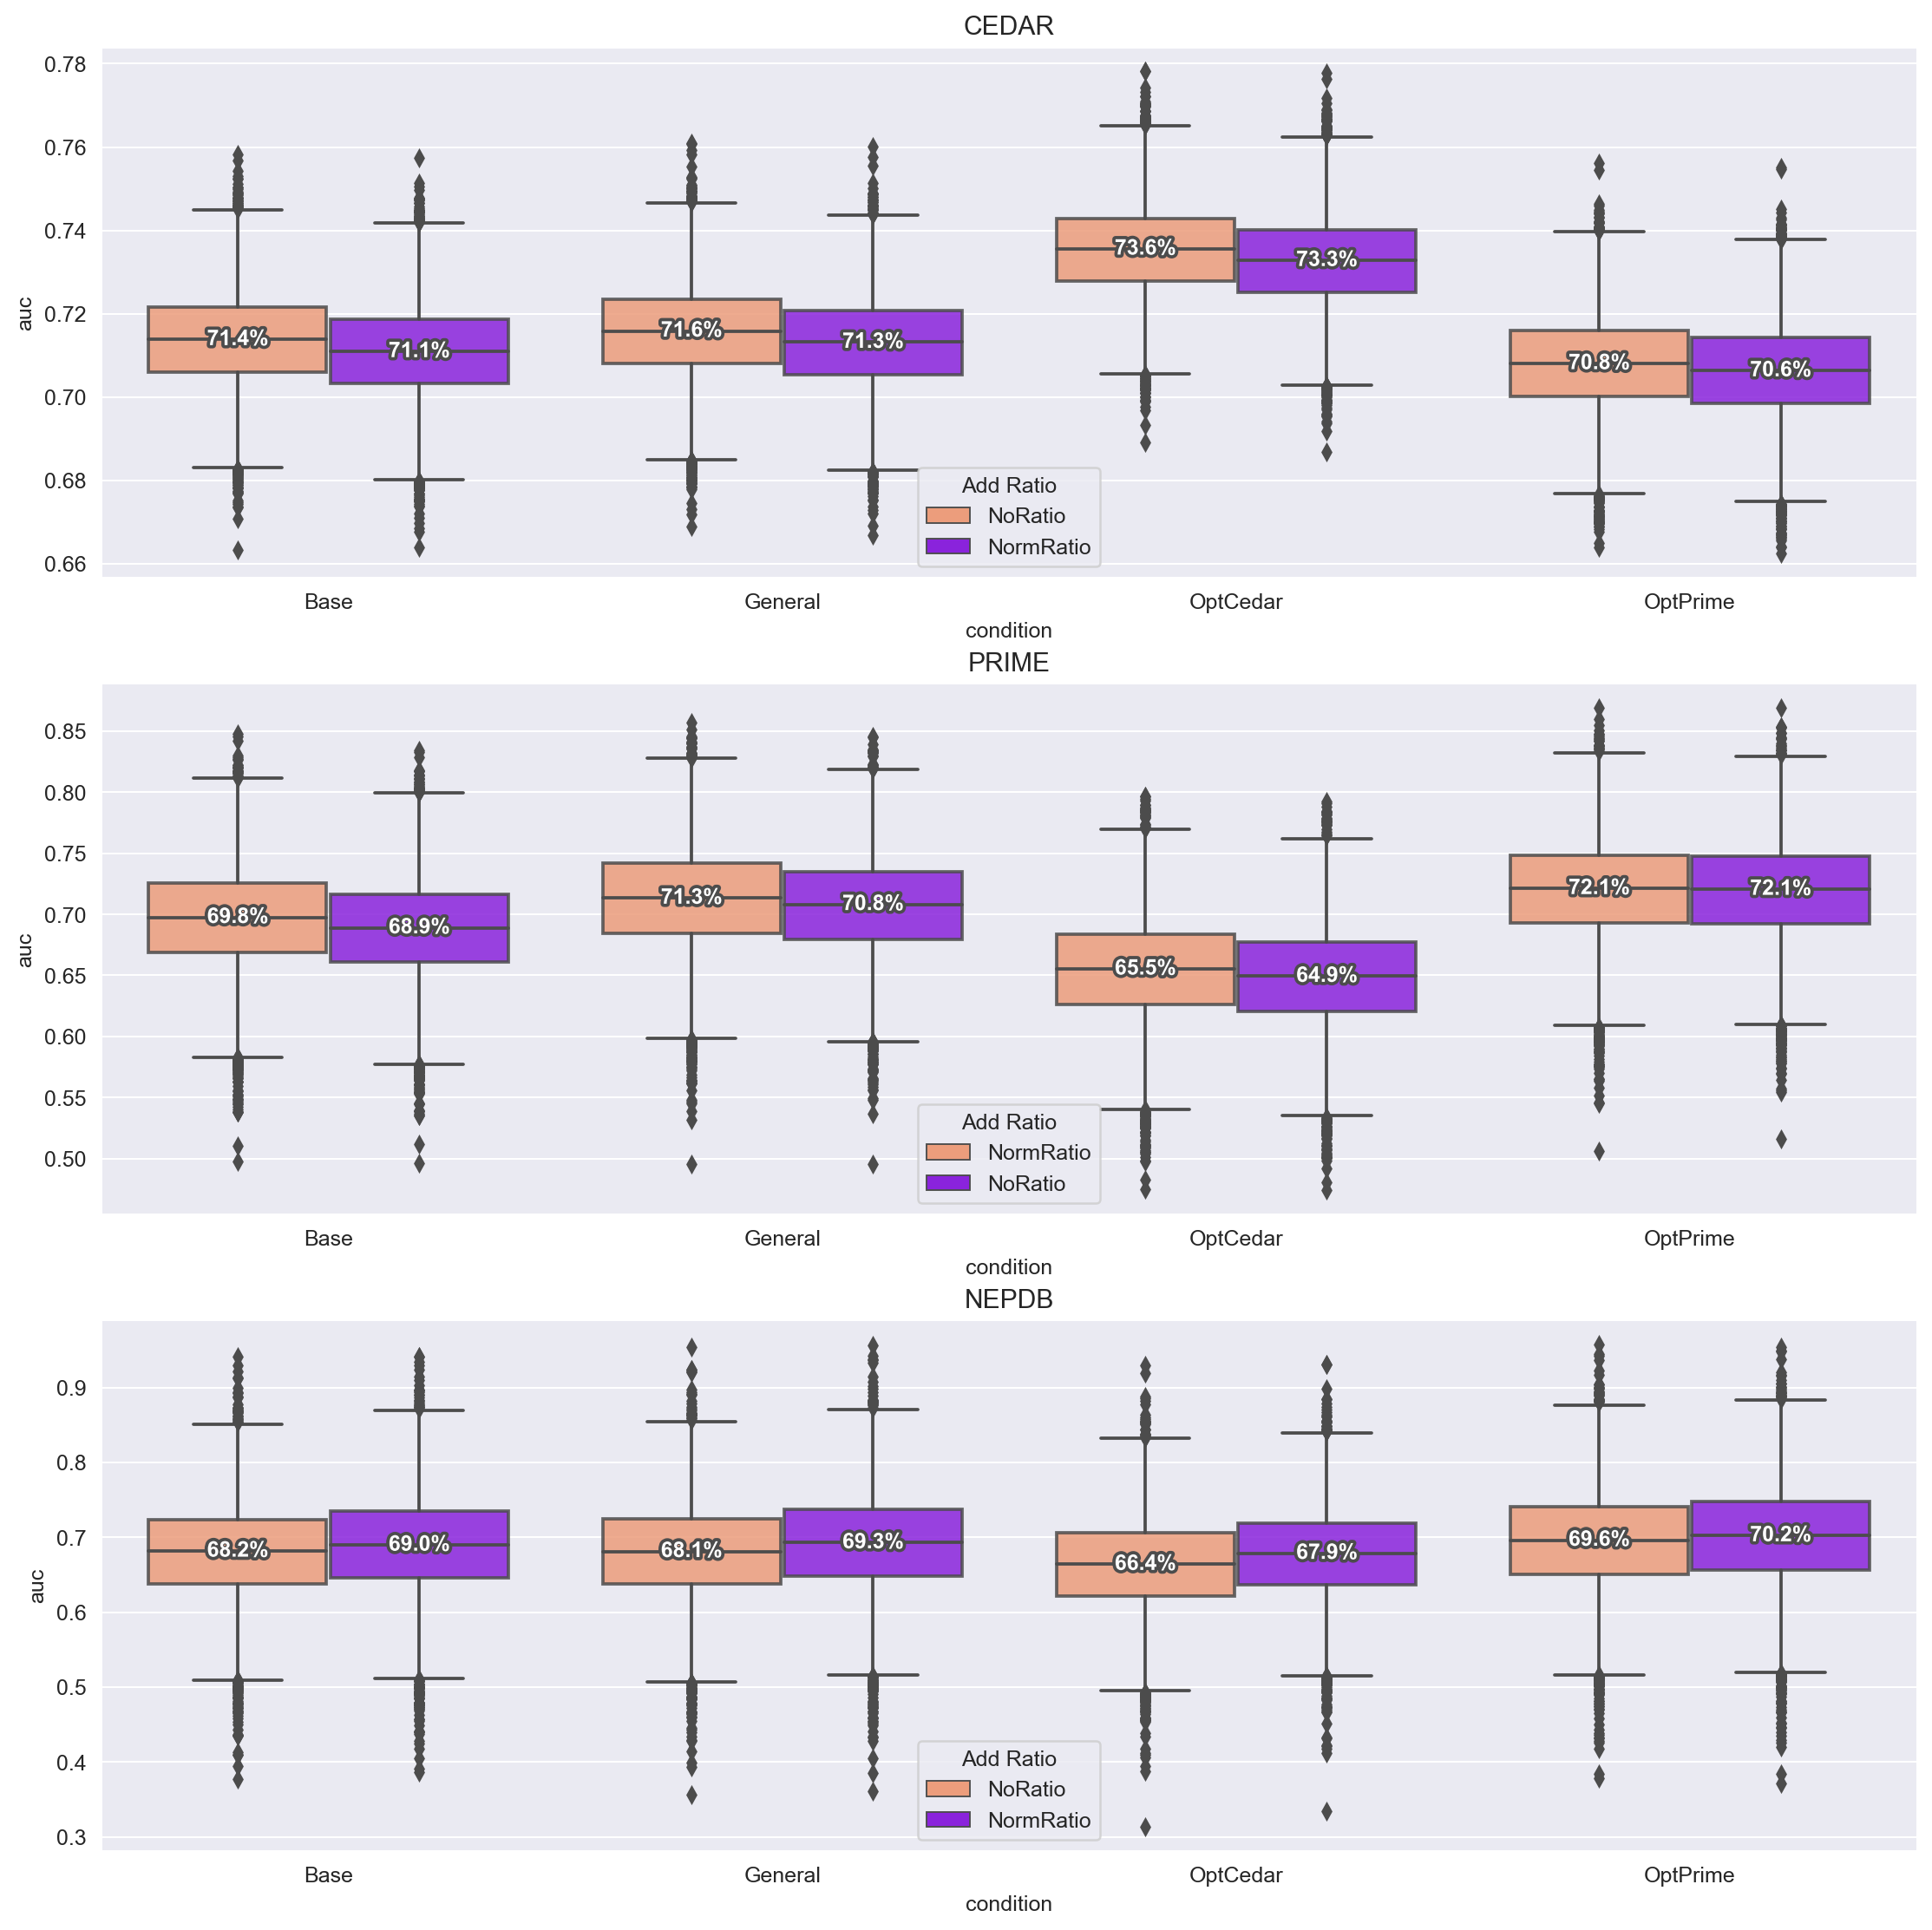

In [250]:
f,a = plt.subplots(3,1, figsize=(15,15))
sns.set_palette(get_palette('gnuplot2_r', 3))
order = ['Base', 'General', 'OptCedar', 'OptPrime']

for evalset, axis in zip(['CEDAR', 'PRIME', 'NEPDB'], a.ravel()):
    axis.set_title(evalset)
    sns.boxplot(data=aligned_df.query('evalset==@evalset'), order = order,
                y = 'auc', x='condition', hue='ratio', ax=axis)
    add_median_labels(axis)
    axis.legend(title='Add Ratio', loc='lower center')
    plt.setp(axis.patches, alpha = 0.85)

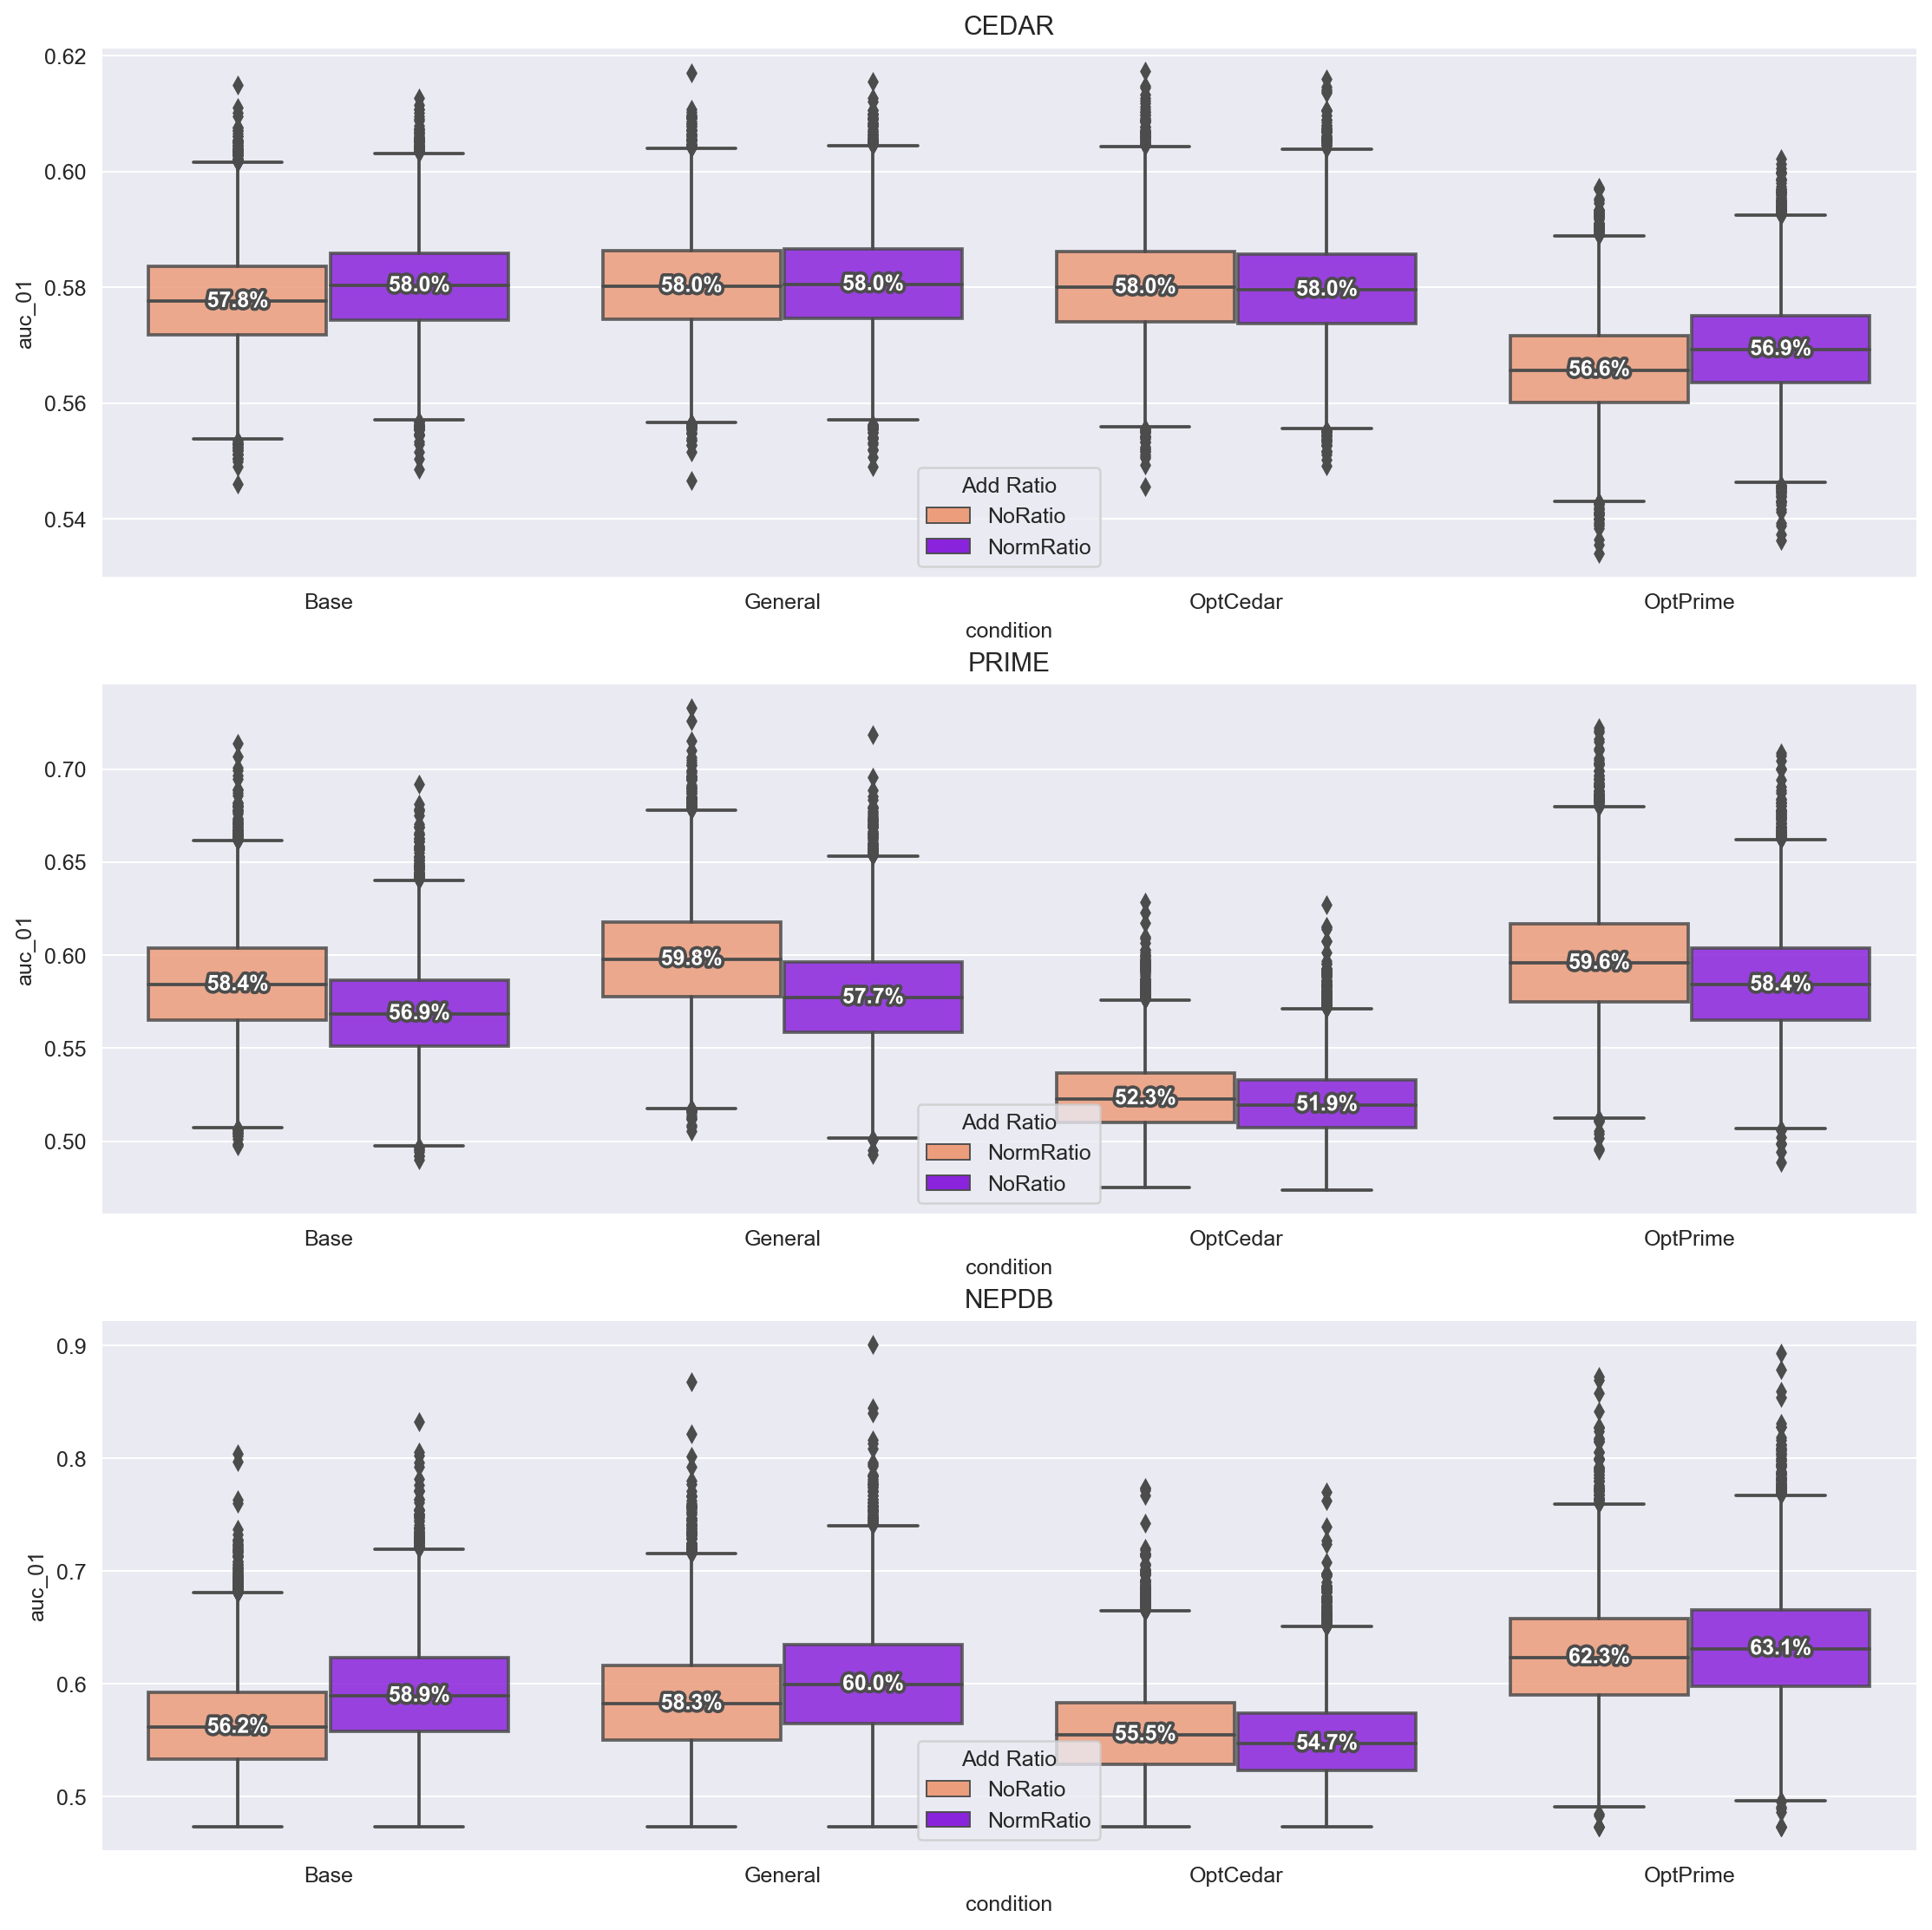

In [248]:
f,a = plt.subplots(3,1, figsize=(15,15))
sns.set_palette(get_palette('gnuplot2_r', 3))
order = ['Base', 'General', 'OptCedar', 'OptPrime']

for evalset, axis in zip(['CEDAR', 'PRIME', 'NEPDB'], a.ravel()):
    axis.set_title(evalset)
    sns.boxplot(data=aligned_df.query('evalset==@evalset'), order = order,
                y = 'auc_01', x='condition', hue='ratio', ax=axis)
    add_median_labels(axis)
    axis.legend(title='Add Ratio', loc='lower center')
    plt.setp(axis.patches, alpha = 0.85)

In [251]:
from sklearn.metrics import roc_auc_score
def get_auc(fn):
    df = pd.read_csv(fn)
    pcol = 'mean_pred' if 'mean_pred' in df.columns else 'pred'
    auc = roc_auc_score(df['agg_label'], df[pcol])
    print(fn, auc)
    return auc

# Redo models with the new Norm Ratio, with or without Expression (To redo analysis 6)

In [315]:
def final_bootstrap_wrapper_expr(preds_df, filename,
                            ic_name, condition_name, add_expr, add_ratio, key, evalset,
                            n_rounds=10000, n_jobs=8):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'icore_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['condition'] = condition_name
    bootstrapped_df['expr'] = add_expr
    bootstrapped_df['ratio'] = add_ratio
    bootstrapped_df['evalset'] = evalset.upper()

    bootstrapped_df.to_csv(
        f'{outdir_expr}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
        index=False)
    pkl_dump(mean_rocs,
             f'{outdir_expr}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

In [316]:
def get_mc(mutcol, add_expr, add_ratio):
    """nique ta daronne la grande folle"""
    if mutcol is None:
        if add_expr and not add_ratio:
            mc = ['Total_Gene_TPM']
        if add_ratio and not add_expr:
            mc = ['ratio_rank']
        if add_expr and add_ratio:
            mc = ['ratio_rank', 'Total_Gene_TPM']
        if not add_expr and not add_ratio:
            mc = None
            
    if mutcol is not None:
        mc = mutcol
        if add_expr:
            mc = mc+['Total_Gene_TPM']
        if add_ratio:
            mc = mc+['ratio_rank']
        
    return mc

In [324]:
from src.utils import mkdirs, pkl_dump
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.metrics import get_nested_feature_importance
from itertools import product 

# Here, do comparison of adding new ratio rank vs not doing anything, using the top 3 models
# Condition = [ic_name, ic_dict, mut_cols]
outdir_expr = '../output/230330_NormRatio_AddNotExpr/'
mkdirs(outdir_expr)
mkdirs(outdir_expr+'bootstrapping/')
mkdirs(outdir_expr+'raw/')
###
cedar_dataset = cedar_aligned_expr
prime_dataset = prime_aligned_expr
nepdb_dataset = nepdb_aligned_expr
train_dataset = cedar_dataset

###
cdt_cedar = ['Inverted-Shannon', ics_shannon, 
             'aliphatic_index-boman-hydrophobicity-isoelectric_point-'\
             'VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-EL_rank_wt_aligned'.split('-')]
cdt_prime = ['Mask', ics_shannon, 'icore_dissimilarity_score-icore_blsm_mut_score'.split('-')]
cdt_gen = ['None', None, 'icore_dissimilarity_score-icore_blsm_mut_score'.split('-')]
cdt_base = ['None', None, None]
mega_df = pd.DataFrame()

cedar_dataset['ratio_rank'] = cedar_dataset.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
prime_dataset['ratio_rank'] = prime_dataset.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
nepdb_dataset['ratio_rank'] = nepdb_dataset.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
            
for (ic_name, ics_dict, mut_cols), condition_name in zip([cdt_cedar, cdt_prime, cdt_gen, cdt_base],
                                     ['OptCedar','OptPrime','General','Base']):
    for add_ratio, add_expr in product([False, True], [False, True]):
        mc = get_mc(mut_cols, add_expr, add_ratio)


        seqcol = 'Peptide' if condition_name == "Base" else 'icore_mut'
        rankcol = 'trueHLA_EL_rank' if condition_name == "Base" else 'EL_rank_mut'

        encoding_kwargs = dict(max_len=12, encoding='onehot', rank_col=rankcol, seq_col=seqcol,
                           blosum_matrix=None, add_rank=True, add_aaprop=False, mut_col = mc,
                           remove_pep=False, standardize=True, invert = ('Inverted' in ic_name), mask = ('Mask' in ic_name))


        key = '-'.join(mc) if mc is not None else 'only_rank'
        key = key.replace('aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8', 'aa_props')
        key = key.replace(' ', '-')
        filename = f'onehot_{"-".join(ic_name.split(" "))}_icore_mut_EL_rank_mut_{condition_name}_AddExpr{add_expr}_AddRatio{add_ratio}_{key}'
        print(add_expr, add_ratio, mc, '\n', filename)
        # Using the same model and hyperparameters
        model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                       max_depth=8, ccp_alpha=9.945e-6)
        # Training model and getting feature importances
        print('Training')
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                    ics_dict=ics_dict,
                                                                    encoding_kwargs=encoding_kwargs,
                                                                    n_jobs=8)
        fi = get_nested_feature_importance(trained_models)
        fn = AA_KEYS + ['rank'] if mc is None else AA_KEYS+['rank'] + mc
        # Saving Feature importances as dataframe
        df_fi = pd.DataFrame(fi, index=fn).T
        df_fi.to_csv(
            f'{outdir_expr}raw/featimps_{filename}.csv',
            index=False)

        for evalset, evalname in zip([cedar_dataset, prime_dataset, nepdb_dataset],
                                     ['CEDAR', 'PRIME', 'NEPDB']):
            # FULLY FILTERED + Mean_pred
            if not evalset.equals(train_dataset):
                evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
            _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                       trained_models, ics_dict,
                                                       train_dataset,
                                                       encoding_kwargs, concatenated=False,
                                                       only_concat=True, n_jobs=8)
            p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
            preds.to_csv(f'{outdir_expr}raw/{evalname}_preds_{filename}.csv', index=False, columns = [p_col, 'Peptide', 'icore_mut', 'EL_rank_mut', 'EL_rank_wt_aligned', 'ratio_rank', 'foreignness_score', 'agg_label', 'HLA'])

            bootstrapped_df = final_bootstrap_wrapper_expr(preds, filename, ic_name, condition_name, add_expr,
                                                           add_ratio, key, evalname, n_rounds=10000, n_jobs = 8)
        del trained_models, bootstrapped_df

False False ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'EL_rank_wt_aligned'] 
 onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprFalse_AddRatioFalse_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprFalse_AddRatioFalse_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprFalse_AddRatioFalse_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprFalse_AddRatioFalse_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned.pkl saved.
True False ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'EL_rank_wt_aligned', 'Total_Gene_TPM'] 
 onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprTrue_AddRatioFalse_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprTrue_AddRatioFalse_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprTrue_AddRatioFalse_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprTrue_AddRatioFalse_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.
False True ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'EL_rank_wt_aligned', 'ratio_rank'] 
 onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprFalse_AddRatioTrue_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprFalse_AddRatioTrue_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprFalse_AddRatioTrue_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprFalse_AddRatioTrue_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-ratio_rank.pkl saved.
True True ['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'EL_rank_wt_aligned', 'Total_Gene_TPM', 'ratio_rank'] 
 onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprTrue_AddRatioTrue_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprTrue_AddRatioTrue_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprTrue_AddRatioTrue_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_OptCedar_AddExprTrue_AddRatioTrue_aa_props-icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM-ratio_rank.pkl saved.
False False ['icore_dissimilarity_score', 'icore_blsm_mut_score'] 
 onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprFalse_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprFalse_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprFalse_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprFalse_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.
True False ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM'] 
 onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprTrue_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprTrue_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprTrue_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprTrue_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM.pkl saved.
False True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank'] 
 onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprFalse_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprFalse_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprFalse_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprFalse_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.
True True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM', 'ratio_rank'] 
 onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprTrue_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprTrue_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprTrue_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_OptPrime_AddExprTrue_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.
False False ['icore_dissimilarity_score', 'icore_blsm_mut_score'] 
 onehot_None_icore_mut_EL_rank_mut_General_AddExprFalse_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprFalse_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprFalse_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprFalse_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score.pkl saved.
True False ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM'] 
 onehot_None_icore_mut_EL_rank_mut_General_AddExprTrue_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprTrue_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprTrue_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprTrue_AddRatioFalse_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM.pkl saved.
False True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank'] 
 onehot_None_icore_mut_EL_rank_mut_General_AddExprFalse_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprFalse_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprFalse_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprFalse_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank.pkl saved.
True True ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM', 'ratio_rank'] 
 onehot_None_icore_mut_EL_rank_mut_General_AddExprTrue_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprTrue_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprTrue_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_General_AddExprTrue_AddRatioTrue_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM-ratio_rank.pkl saved.
False False None 
 onehot_None_icore_mut_EL_rank_mut_Base_AddExprFalse_AddRatioFalse_only_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprFalse_AddRatioFalse_only_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprFalse_AddRatioFalse_only_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprFalse_AddRatioFalse_only_rank.pkl saved.
True False ['Total_Gene_TPM'] 
 onehot_None_icore_mut_EL_rank_mut_Base_AddExprTrue_AddRatioFalse_Total_Gene_TPM
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprTrue_AddRatioFalse_Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprTrue_AddRatioFalse_Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprTrue_AddRatioFalse_Total_Gene_TPM.pkl saved.
False True ['ratio_rank'] 
 onehot_None_icore_mut_EL_rank_mut_Base_AddExprFalse_AddRatioTrue_ratio_rank
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprFalse_AddRatioTrue_ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprFalse_AddRatioTrue_ratio_rank.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprFalse_AddRatioTrue_ratio_rank.pkl saved.
True True ['ratio_rank', 'Total_Gene_TPM'] 
 onehot_None_icore_mut_EL_rank_mut_Base_AddExprTrue_AddRatioTrue_ratio_rank-Total_Gene_TPM
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprTrue_AddRatioTrue_ratio_rank-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprTrue_AddRatioTrue_ratio_rank-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230330_NormRatio_AddNotExpr/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_Base_AddExprTrue_AddRatioTrue_ratio_rank-Total_Gene_TPM.pkl saved.


In [327]:
outdir_expr = '../output/230330_NormRatio_AddNotExpr/'
expr_df = pd.concat([pd.read_csv(f'{outdir_expr}bootstrapping/{x}') for x in os.listdir(outdir_expr+'bootstrapping/') \
                     if x.endswith('csv')])
expr_df['hue'] = expr_df.apply(lambda x : f"Expr{x['expr']}_Ratio{x['ratio']}", axis=1)
expr_df.groupby(['condition', 'expr', 'ratio', 'evalset']).count()

auc  prauc     AP  auc_01     f1  accuracy  \
condition expr  ratio evalset                                                 
Base      False False CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
                True  CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
          True  False CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
                True  CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
General   False False CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
                True  CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
          True  False CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
                True  CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
OptCedar  False False CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
                True  CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
          True  False CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
                True  CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
OptPrime  False False CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
                True  CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
          True  False CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   
                True  CEDAR    10000  10000  10000   10000  10000     10000   
                      NEPDB    10000  10000  10000   10000  10000     10000   
                      PRIME    10000  10000  10000   10000  10000     10000   

                               precision  recall  encoding  weight  pep_col  \
con

In [334]:
hue_order = ['ExprFalse_RatioFalse', 'ExprTrue_RatioFalse', 'ExprFalse_RatioTrue', 'ExprTrue_RatioTrue']

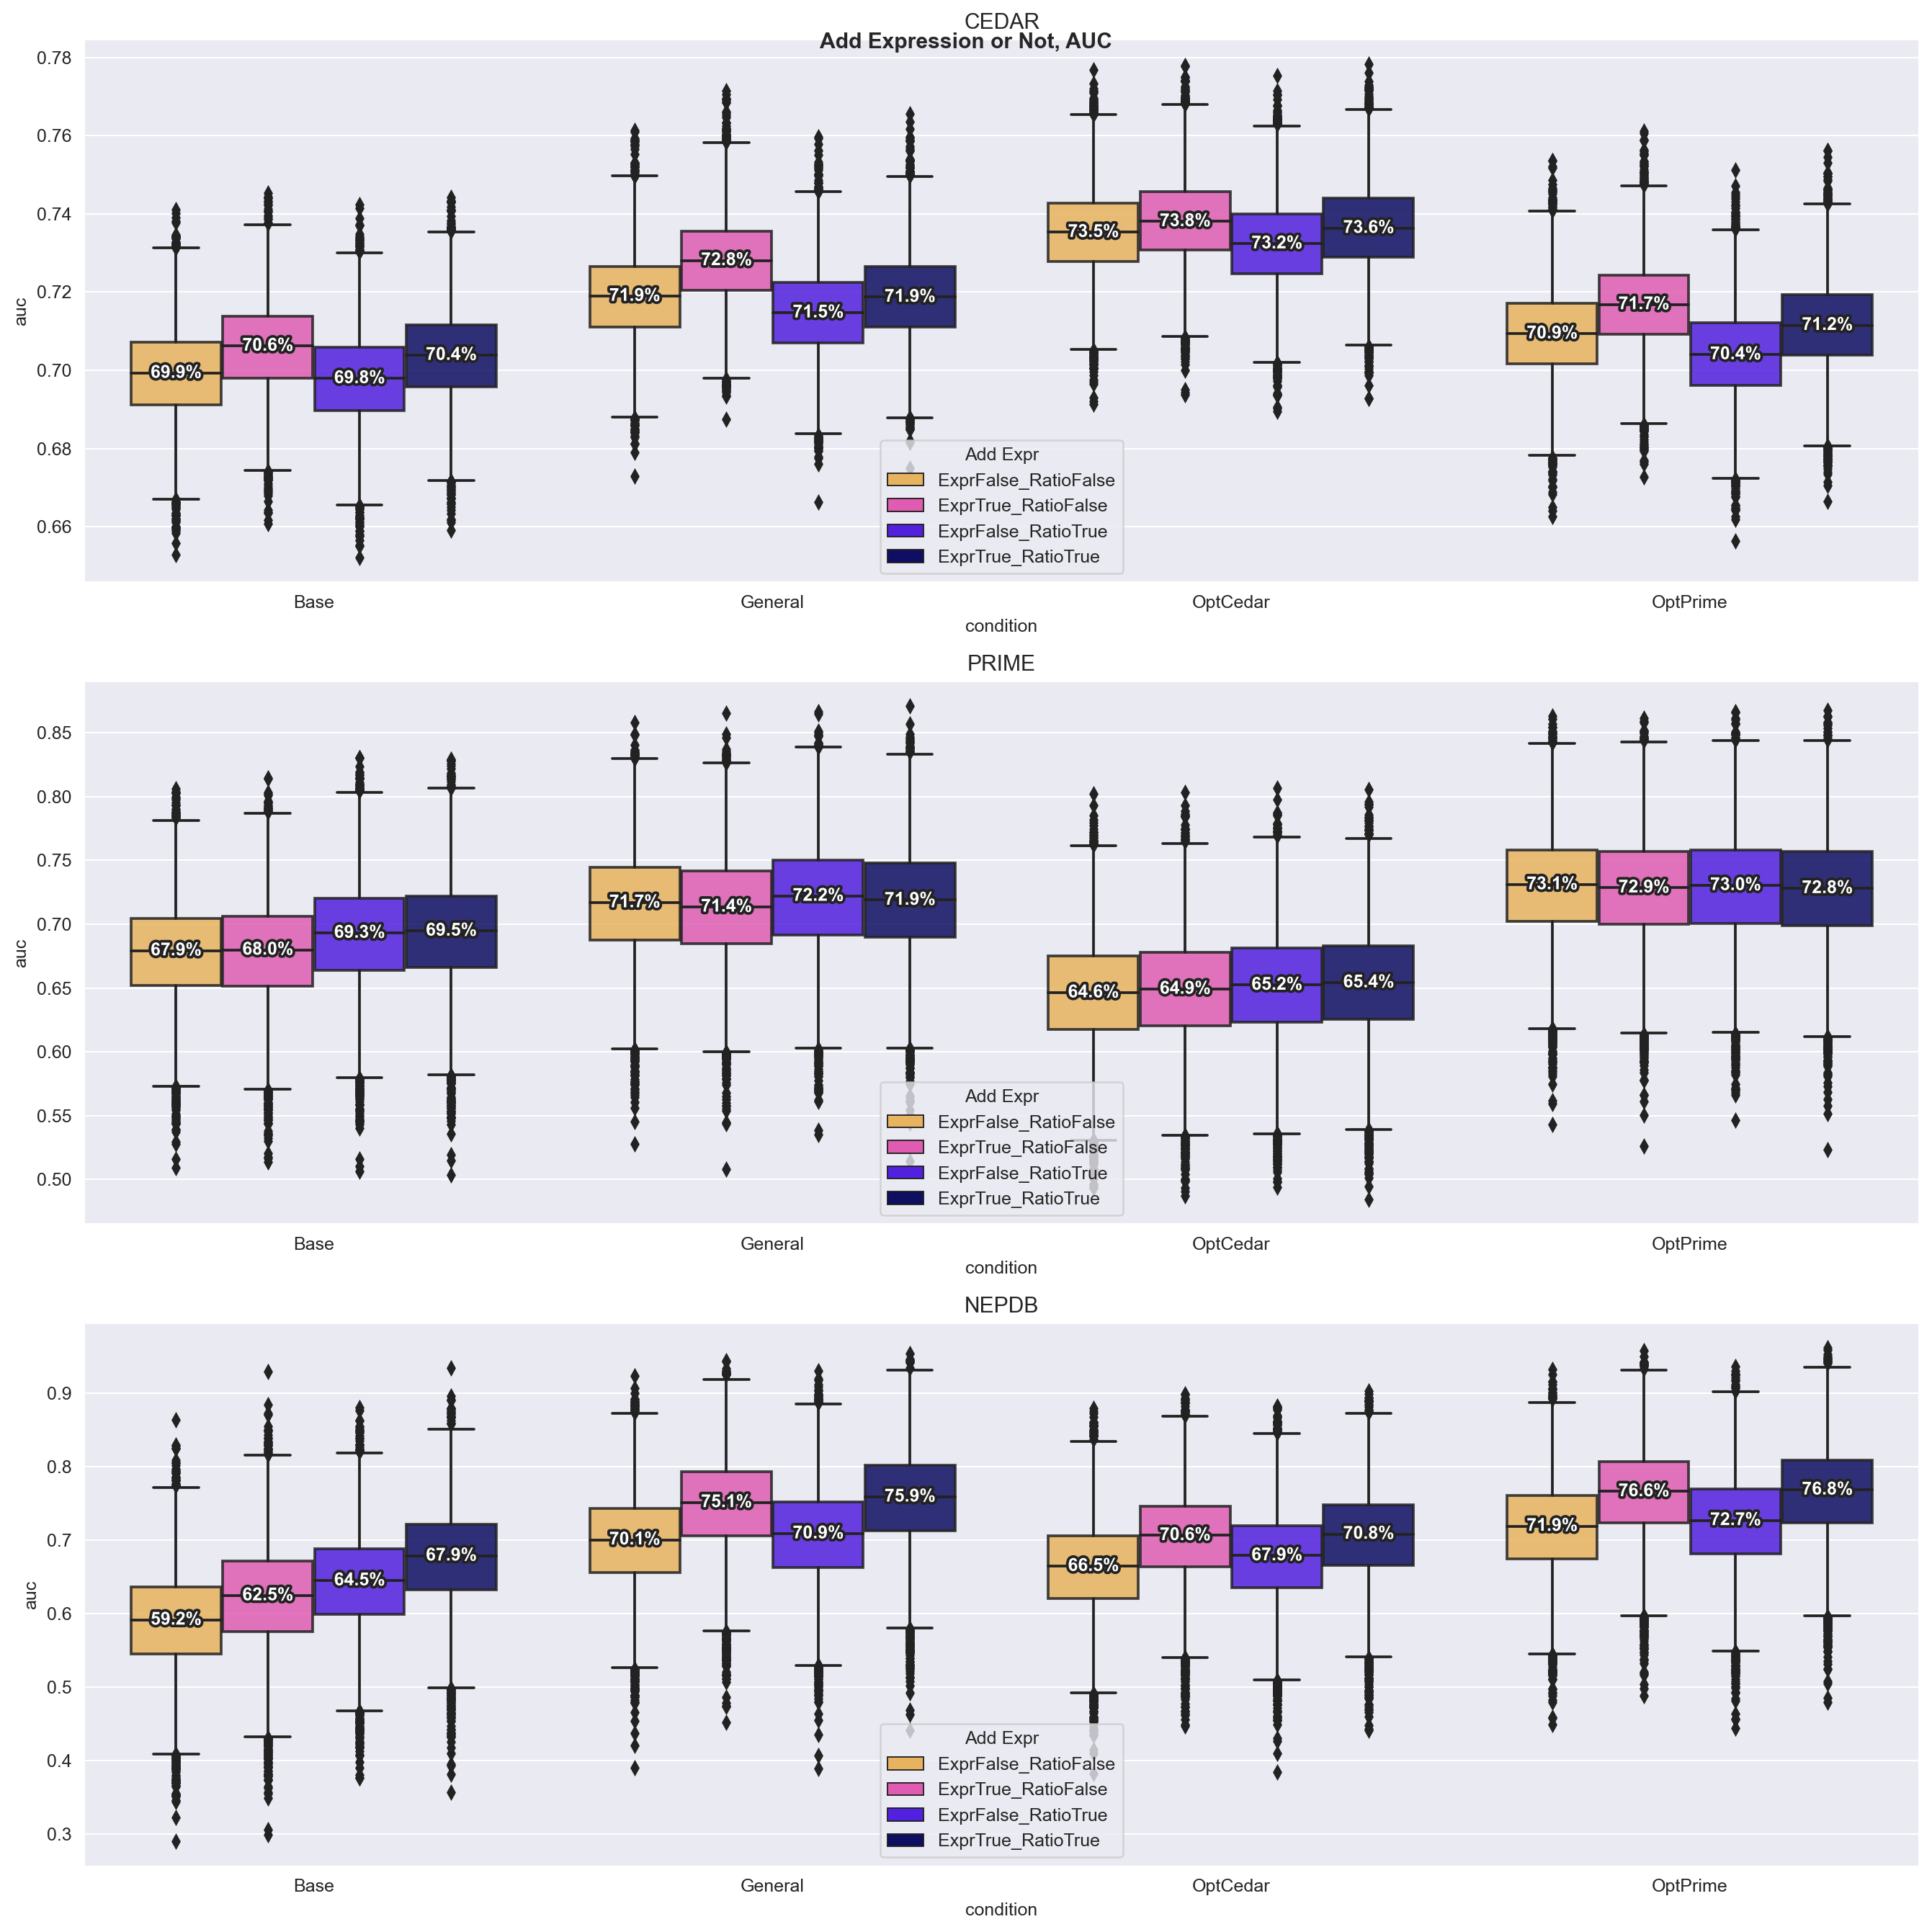

In [338]:
f,a = plt.subplots(3,1, figsize=(15,15))
sns.set_palette(get_palette('gnuplot2_r', 4))
order = ['Base', 'General', 'OptCedar', 'OptPrime']


for evalset, axis in zip(['CEDAR', 'PRIME', 'NEPDB'], a.ravel()):
    axis.set_title(evalset)
    sns.boxplot(data=expr_df.query('evalset==@evalset'), order = order, hue_order=hue_order,
                y = 'auc', x='condition', hue='hue', ax=axis)
    add_median_labels(axis)
    axis.legend(title='Add Expr', loc='lower center')
    plt.setp(axis.patches, alpha = 0.85)
f.tight_layout()
f.suptitle('Add Expression or Not, AUC', fontweight='semibold', fontsize=12)
f.savefig('../../../writing/230131_cedar_paper_1/figures/add_Expr_newAddRatio')

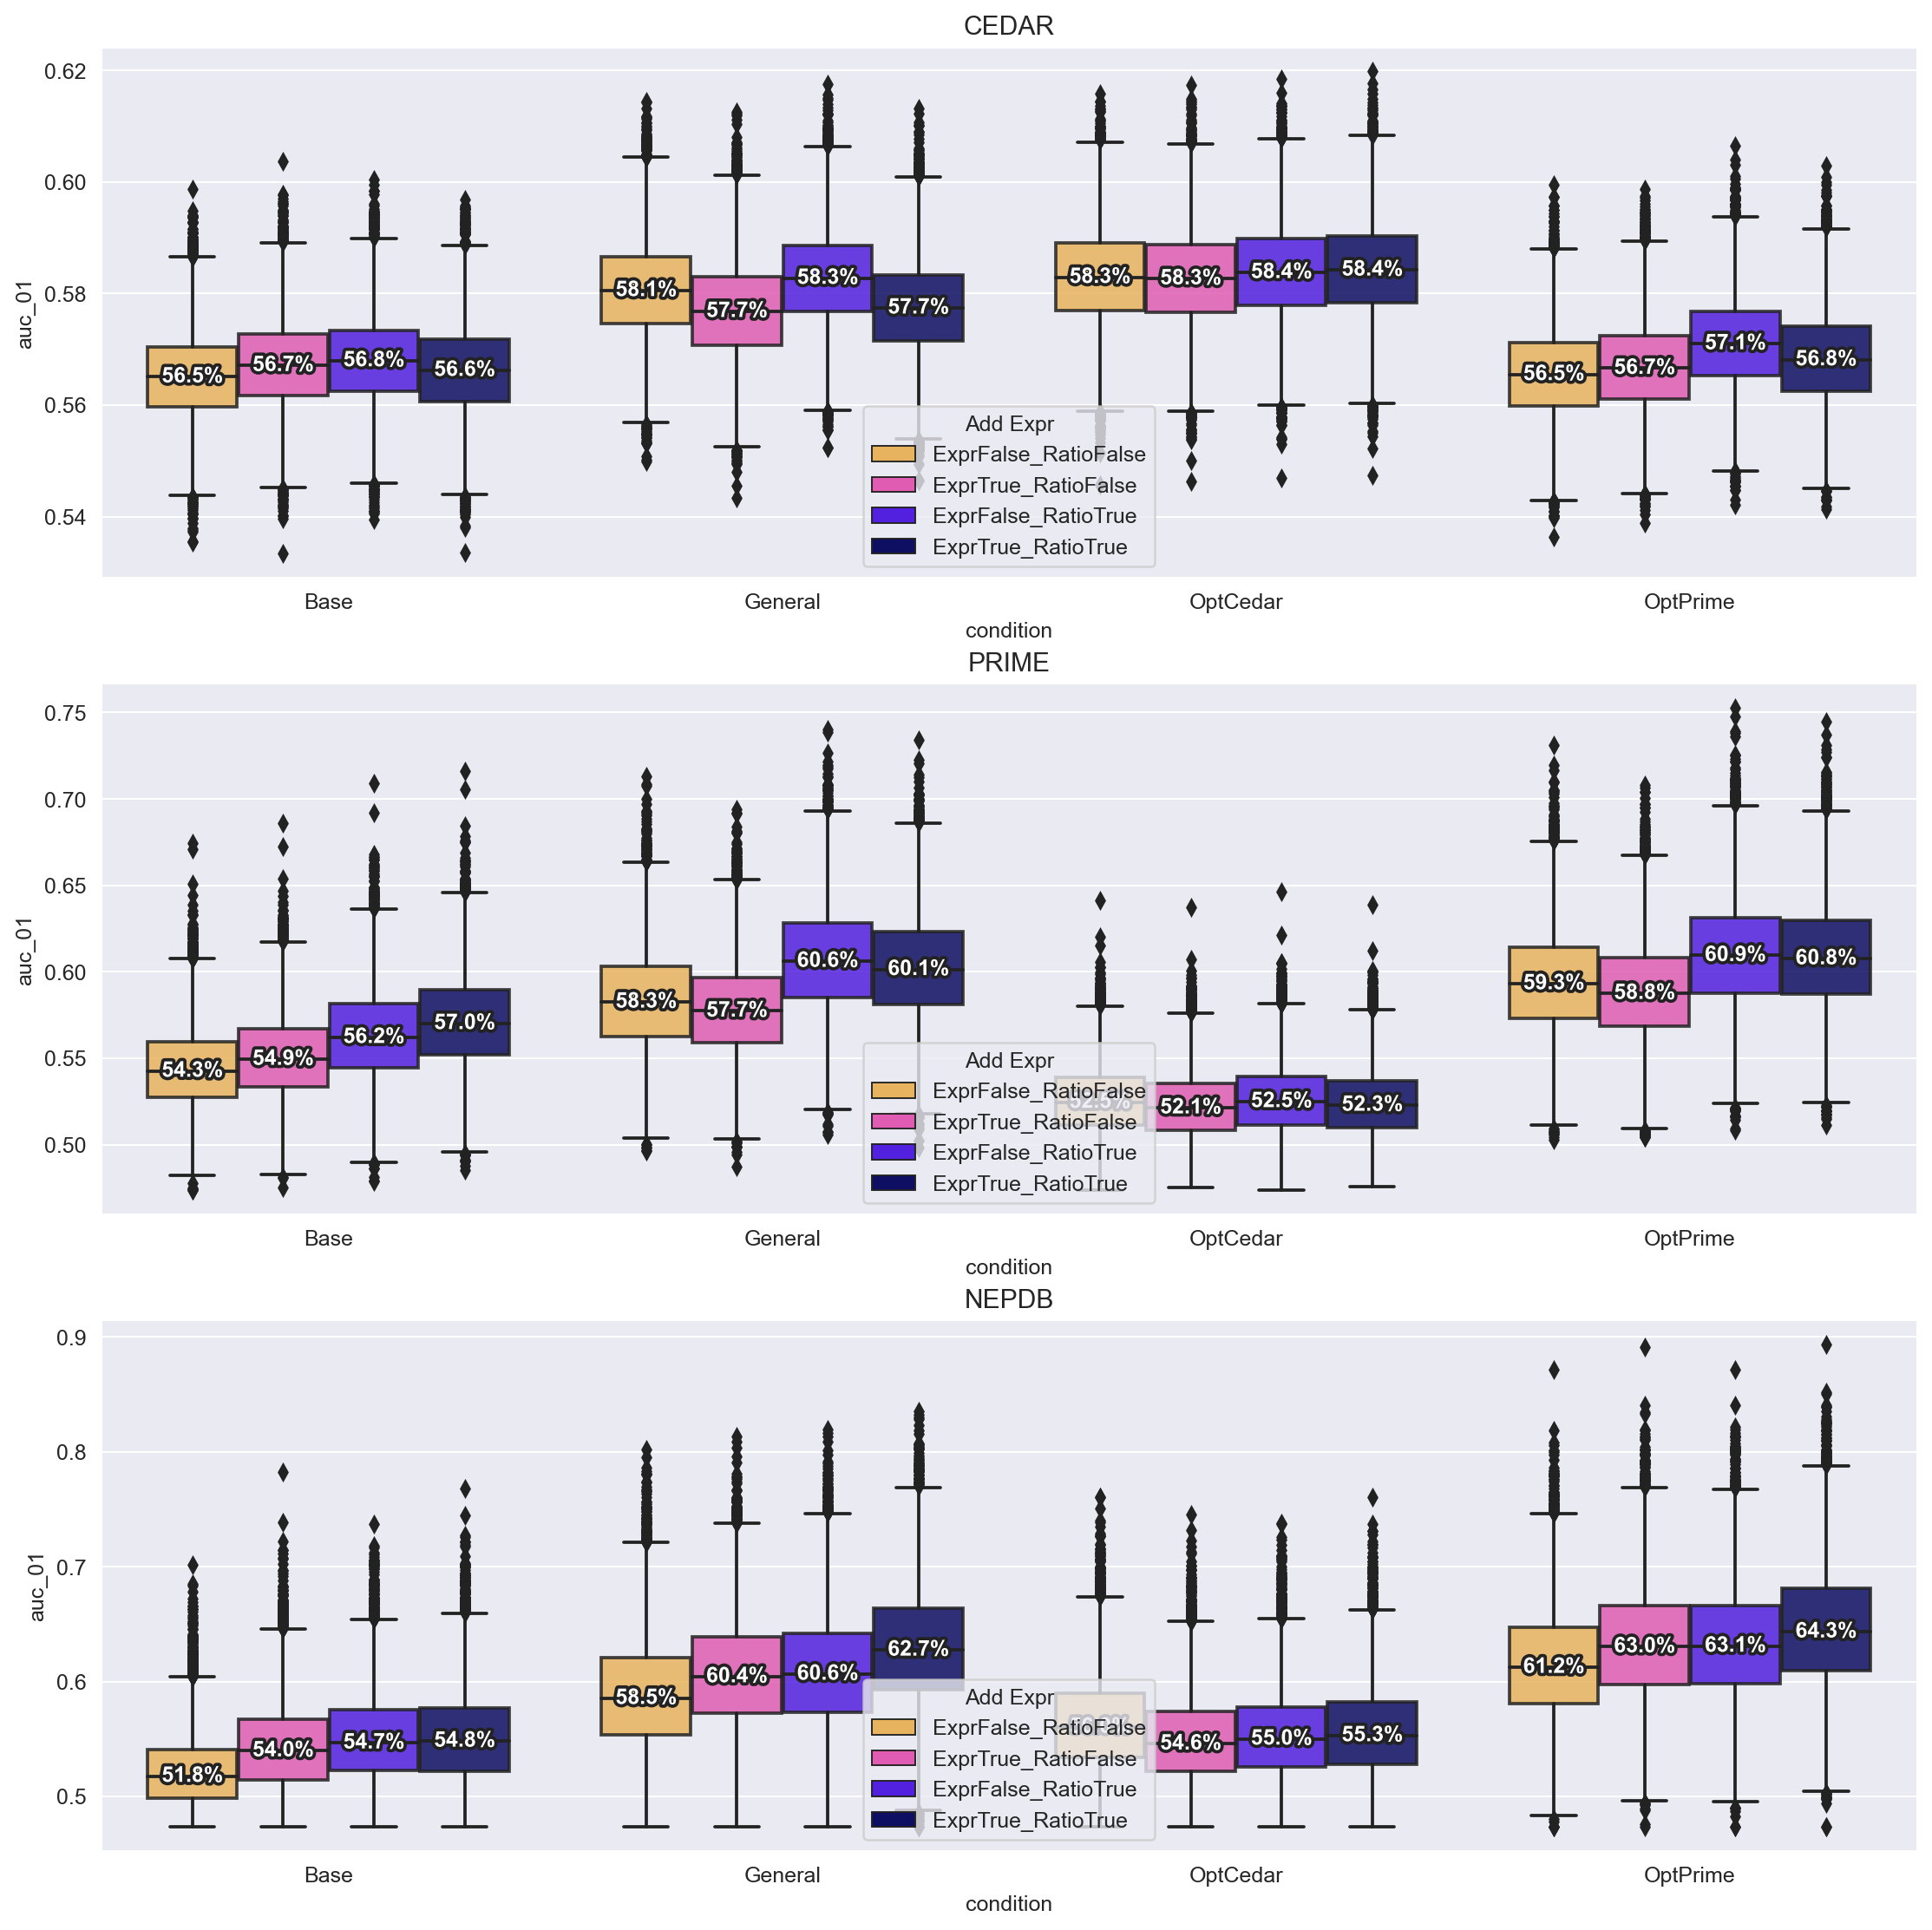

In [339]:
f,a = plt.subplots(3,1, figsize=(15,15))
sns.set_palette(get_palette('gnuplot2_r', 4))
order = ['Base', 'General', 'OptCedar', 'OptPrime']
for evalset, axis in zip(['CEDAR', 'PRIME', 'NEPDB'], a.ravel()):
    axis.set_title(evalset)
    sns.boxplot(data=expr_df.query('evalset==@evalset'), order = order,  hue_order=hue_order,
                y = 'auc_01', x='condition', hue='hue', ax=axis)
    add_median_labels(axis)
    axis.legend(title='Add Expr', loc='lower center')
    plt.setp(axis.patches, alpha = 0.85)

## Remake the graph for part 6, Expression vs not graph

In [344]:
cedar_aligned['nmut'] = cedar_aligned['icore_mutation_position'].apply(lambda x: 1+x.count(','))

In [351]:
cedar_aligned.query('nmut==3')[['icore_mut', 'icore_wt_aligned','icore_mutation_position']]

icore_mut icore_wt_aligned icore_mutation_position
614     FRYYRVSIL        FRIYAVSTL                   2,4,7
870     HQFHVHPLL        HRFHVHPKS                   1,7,8
1034    ISIQRAQPL        LKLQRAQPL                   0,1,2
1232  KPPKAKPSPTY      KPPKAKPASTV                  7,8,10
1260     KSDIGWIW         SSDIGWVL                   0,6,7
1430    HASFVTLGK        PACSVTLGK                   0,2,3
1535   LPSFRPPTAL       LPSLRPPTQP                   3,8,9
2125    RVALLSWTK        EGVLLSWTK                   0,1,2
2154    RYYRVSILL        NPRRVSILL                   0,1,2
2383    SSCAPPLHR        SSCAPPPPP                   6,7,8

# Resave all the models with the updated ratio ranks

In [353]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230308_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230308_nepdb_aligned_icore.csv')
cedar_aligned_expr = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230308_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')

In [356]:
cedar_aligned['ratio_rank'] = cedar_aligned.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * x['EL_rank_mut'] / x['EL_rank_wt_aligned'], axis=1)
prime_aligned['ratio_rank'] = prime_aligned.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * x['EL_rank_mut'] / x['EL_rank_wt_aligned'], axis=1)
ibel_aligned['ratio_rank'] = ibel_aligned.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * x['EL_rank_mut'] / x['EL_rank_wt_aligned'], axis=1)
nepdb_aligned['ratio_rank'] = nepdb_aligned.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * x['EL_rank_mut'] / x['EL_rank_wt_aligned'], axis=1)
cedar_aligned_expr['ratio_rank'] = cedar_aligned_expr.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * x['EL_rank_mut'] / x['EL_rank_wt_aligned'], axis=1)
prime_aligned_expr['ratio_rank'] = prime_aligned_expr.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * x['EL_rank_mut'] / x['EL_rank_wt_aligned'], axis=1)
ibel_aligned_expr['ratio_rank'] = ibel_aligned_expr.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * x['EL_rank_mut'] / x['EL_rank_wt_aligned'], axis=1)
nepdb_aligned_expr['ratio_rank'] = nepdb_aligned_expr.apply(lambda x: abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']) * x['EL_rank_mut'] / x['EL_rank_wt_aligned'], axis=1)

In [357]:
cedar_aligned.to_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned.to_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')
ibel_aligned.to_csv('../data/aligned_icore/230308_ibel_aligned_icore.csv')
nepdb_aligned.to_csv('../data/aligned_icore/230308_nepdb_aligned_icore.csv')
cedar_aligned_expr.to_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr.to_csv('../data/pepx/230308_prime_aligned_pepx.csv')
ibel_aligned_expr.to_csv('../data/pepx/230308_ibel_aligned_pepx.csv')
nepdb_aligned_expr.to_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')